#Implementación y pruebas de modelos




##Características de calidad de los datos

Según la información de la documentación inicial del caso, se notó como la empresa cuenta con información comercial y con información técnica reportada por el medidor para cada uno de sus clientes no regulados.

Respecto a la información comercial, Electro Dunas cuenta con una base de datos que continene el número de identificación del cliente, el Departamento, la
Provincia, el Distrito, la Subestación, las Coordenadas de localización, entre otros (base de datos 1).

Además, la información técnica corresponde a los valores históricos de la energía acDva entregada1 (kWh), la energía reacDva entregada2 (kVarh) y el voltaje reportado cada 15 minutos por el medidor decada cliente (base de datos 2).

Se corroboran los datos alojados en el repositorio https://github.com/Pacheco-Carvajal/GPA-Data-ElectroDunas

Tal como se describe en el planteamiento inicial del problema, se cuenta con una primera base en el repositorio con el nombre "sector_economico_clientes.xlsx", esta base de datos enumera los clientes y su sector económico, a diferencia de lo planteado en la documentación inicial no se encuentra evidencia del departamento, distrito, subestación entre otros elementos mencionados.

Con respecto a la información técnica, se encuentran 30 archivos en formato CSV (archivos separados por comas) con la información técnica del cliente correspondiente al archivo, se tiene entonces la fecha en la que se tomó la medición, energía activa, energía reactiva, voltaje FA y voltaje FC. Si bien las bases de datos parecen coincidir con la información inicial reportada por la empresa es de resaltar que los intervalos de tiempo no corresponden a reportes hechos cada 15 minutos.

Mediante Excel, y usando la función xlookup se agrupan todas estas bases de datos en un mismo archivo que se utilizará para la realización de este proyecto.



In [5]:
!pip install hdbscan
!pip install pmdarima
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [7]:
#Librerias

import time
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from kerastuner.tuners import RandomSearch
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import hdbscan
from sklearn.cluster import KMeans

In [ ]:
import pandas as pd
#Se importa el archivo mencionado anteriormente con el fin de proceder a su exploración.
df = pd.read_excel("Clientes consolidada.xlsx")
#Se imprime el dataframe resultante.
df

,Source.Name,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,CLIENTE,Proper,Sector Económico:
0,DATOSCLIENTE1.csv,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,CLIENTE 1,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,DATOSCLIENTE1.csv,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,CLIENTE 1,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,DATOSCLIENTE1.csv,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,CLIENTE 1,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,DATOSCLIENTE1.csv,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,CLIENTE 1,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,DATOSCLIENTE1.csv,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,CLIENTE 1,Cliente 1,Elaboración de cacao y chocolate y de producto...
...,...,...,...,...,...,...,...,...,...
463420,DATOSCLIENTE9.csv,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,CLIENTE 9,Cliente 9,Cultivo de Árboles Frutales y Nueces
463421,DATOSCLIENTE9.csv,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,CLIENTE 9,Cliente 9,Cultivo de Árboles Frutales y Nueces
463422,DATOSCLIENTE9.csv,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,CLIENTE 9,Cliente 9,Cultivo de Árboles Frutales y Nueces
463423,DATOSCLIENTE9.csv,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,CLIENTE 9,Cliente 9,Cultivo de Árboles Frutales y Nueces


**Totalidad**

Como primer paso a la exploración de las características de los datos se comienza explorando la base de datos desde la dimensión de totalidad con el fin de corroborar que todos los campos de la base de datos estén correctos.

In [ ]:
#Se exploran si existen valores nulos en la base de datos.
df_info = df.isnull().sum()
print(df_info)

Fecha                0
Active_energy        0
Reactive_energy      0
Voltaje_FA           0
Voltaje_FC           0
Proper               0
Sector Económico:    0
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463425 entries, 0 to 463424
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Fecha              463425 non-null  datetime64[ns]
 1   Active_energy      463425 non-null  float64       
 2   Reactive_energy    463425 non-null  float64       
 3   Voltaje_FA         463425 non-null  float64       
 4   Voltaje_FC         463425 non-null  float64       
 5   Proper             463425 non-null  object        
 6   Sector Económico:  463425 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 24.7+ MB


Desde la óptica de la dimensión de totalidad, puede primero observarse que se obtiene una base de datos total en forma de dataframe almacenada en la variable "df" con 463425 filas o registros y 9 columnas o dimensiones.

Luego, mediante la librería pandas y los atributos de exploración de dataframes, se explora un poco más a fondo la base de datos y puede observarse que no hay ningún valor faltante (o null) dentro de las columnas, es decir, cada una de las columnas cuenta con 463425 elementos.

Adicional a esto, también puede verificarse el tipo de datos que tiene cada columna de la siguiente forma:


*   Fecha: contiene la fecha y la hora en la cuál se hizo medición de las variables eléctricas mencionadas anteriormente para un determinado cliente, su formato es datetime64 ya que es una variable de tiempo.

*   Active_energy: contiene la energía activa registrada en esa medición el particular, su formato es float64 ya que es una variable decimal.

*   Reactive_energy: contiene la energía activa reactiva en esa medición el particular, su formato es float64 ya que es una variable decimal.

*   Voltaje_FA: contiene el voltaje FA registrado en esa medición en particular, su formato es float64 ya que es una variable decimal.

*   Voltaje_FC: contiene el voltaje FC registrado en esa medición en particular, su formato es float64 ya que es una variable decimal.

*   CLIENTE: Contiene el indicador del cliente al cual pertenece el registro, su formato es object ya que es una variable en forma de cadenas de texto.

*   Proper: Contiene el indicador del cliente al cual pertenece el registro, su formato es object ya que es una variable en forma de cadenas de texto.

*   Sector Económico: Contiene el sector económico del cliente al cual pertenece el registro, su formato es object ya que es una variable en forma de cadenas de texto.

In [ ]:
num_celdas_vacias = df.isin([""]).sum().sum()
num_celdas_vacias_por_columna = df.isin([""]).sum()
num_total_celdas_vacias_por_columna = num_celdas_vacias_por_columna.sum()

print(f"Número total de celdas vacías: {num_celdas_vacias}")
print(f"Número total de celdas vacías por columna: {num_total_celdas_vacias_por_columna}")


Número total de celdas vacías: 0
Número total de celdas vacías por columna: 0


Adicional al análisis anterior, se hace un análisis extra considerando la forma "" ya que es común encontrar bases de datos que python toma como si tuvieran datos pero realmente tienen cadenas de texto vacías, no es el caso para la base de datos ya que no se evidencia ningún elemento de la forma de cadena vacía "".

**Consistencia**

Se exploran los datos mediante las diferentes dimensiones con el fin de verificar que exista coherencia entre el sentido de un campo y la definición propia de los datos.

In [ ]:
# Verificar duplicados en fechas para el mismo cliente
duplicates = df[df.duplicated(subset=['CLIENTE', 'Fecha'])]
print("Duplicados en fechas para el mismo cliente:")
print(duplicates)

Duplicados en fechas para el mismo cliente:
Empty DataFrame
Columns: [Fecha, Active_energy, Reactive_energy, Voltaje_FA, Voltaje_FC, Proper, Sector Económico:]
Index: []


In [ ]:
# Verificar valores negativos en Active_energy y Reactive_energy
negative_energy = df[(df['Active_energy'] < 0) | (df['Reactive_energy'] < 0)]
print("Valores negativos en energía:")
negative_energy

Valores negativos en energía:


,Source.Name,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,CLIENTE,Proper,Sector Económico:
133780,DATOSCLIENTE17.csv,2021-11-09 15:00:00,-0.381904,0.382493,2077.430688,2093.655684,CLIENTE 17,Cliente 17,"Captación, tratamiento y distribución de agua"
133781,DATOSCLIENTE17.csv,2021-11-09 16:00:00,-0.408740,0.469523,2036.334551,2093.205889,CLIENTE 17,Cliente 17,"Captación, tratamiento y distribución de agua"
133789,DATOSCLIENTE17.csv,2021-11-10 00:00:00,-0.187803,0.392220,1950.083873,1951.344805,CLIENTE 17,Cliente 17,"Captación, tratamiento y distribución de agua"
133790,DATOSCLIENTE17.csv,2021-11-10 01:00:00,-0.455174,0.459796,1931.903407,1858.665907,CLIENTE 17,Cliente 17,"Captación, tratamiento y distribución de agua"
133791,DATOSCLIENTE17.csv,2021-11-10 02:00:00,-0.338941,0.390148,1910.706034,2064.042938,CLIENTE 17,Cliente 17,"Captación, tratamiento y distribución de agua"
...,...,...,...,...,...,...,...,...,...
216302,DATOSCLIENTE20.csv,2022-05-09 12:00:00,-0.457582,0.200000,2069.593516,2077.851435,CLIENTE 20,Cliente 20,"Captación, tratamiento y distribución de agua"
216303,DATOSCLIENTE20.csv,2022-05-09 13:00:00,-0.458964,1.484933,2078.795633,2073.401393,CLIENTE 20,Cliente 20,"Captación, tratamiento y distribución de agua"
216304,DATOSCLIENTE20.csv,2022-05-09 14:00:00,-0.427294,0.231000,2071.330458,2079.444732,CLIENTE 20,Cliente 20,"Captación, tratamiento y distribución de agua"
216305,DATOSCLIENTE20.csv,2022-05-09 15:00:00,-0.455775,0.200000,2039.538550,2088.843514,CLIENTE 20,Cliente 20,"Captación, tratamiento y distribución de agua"


In [ ]:
# Verificar valores negativos en Voltaje_FA y Voltaje_FC
negative_volt = df[(df['Voltaje_FA'] < 0) | (df['Voltaje_FC'] < 0)]
print("Valores negativos en voltaje:")
negative_volt

Valores negativos en voltaje:


,Source.Name,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,CLIENTE,Proper,Sector Económico:


In [ ]:
unique_clients = df['CLIENTE'].unique()
unique_proper = df['Proper'].unique()
unique_sectors = df['Sector Económico:'].unique()
print("Clientes únicos:", unique_clients)
print("Proper únicos:", unique_proper)
print("Sectores económicos únicos:", unique_sectors)

Clientes únicos: ['Cliente 1' 'Cliente 10' 'Cliente 11' 'Cliente 12' 'Cliente 13'
 'Cliente 14' 'Cliente 15' 'Cliente 16' 'Cliente 17' 'Cliente 18'
 'Cliente 19' 'Cliente 2' 'Cliente 20' 'Cliente 21' 'Cliente 22'
 'Cliente 23' 'Cliente 24' 'Cliente 25' 'Cliente 26' 'Cliente 27'
 'Cliente 28' 'Cliente 29' 'Cliente 3' 'Cliente 30' 'Cliente 4'
 'Cliente 5' 'Cliente 6' 'Cliente 7' 'Cliente 8' 'Cliente 9']
Proper únicos: ['Cliente 1' 'Cliente 10' 'Cliente 11' 'Cliente 12' 'Cliente 13'
 'Cliente 14' 'Cliente 15' 'Cliente 16' 'Cliente 17' 'Cliente 18'
 'Cliente 19' 'Cliente 2' 'Cliente 20' 'Cliente 21' 'Cliente 22'
 'Cliente 23' 'Cliente 24' 'Cliente 25' 'Cliente 26' 'Cliente 27'
 'Cliente 28' 'Cliente 29' 'Cliente 3' 'Cliente 30' 'Cliente 4'
 'Cliente 5' 'Cliente 6' 'Cliente 7' 'Cliente 8' 'Cliente 9']
Sectores económicos únicos: ['Elaboración de cacao y chocolate y de productos de confitería'
 'Cultivo de Árboles Frutales y Nueces'
 'Cultivo de otros frutos y nueces de árboles y arbustos'
 

In [ ]:
print(df['Fecha'].min(), df['Fecha'].max())


2021-01-01 00:00:00 2023-04-01 00:00:00


Con el fin de analizar la consistencia de los datos, se analizan varias columnas de la base de datos, primero, en la columna de fecha, se analiza que no existan fechas repetidas dentro de un mismo cliente lo cuál sería evidencia de conteos de energía repetidos, luego de hacer el análisis no se observa evidencia de esto.

Luego, ya que estamos analizando mediciones de energía, se procede a evaluar inconsistencias con respecto a mediciones erróneas de energía, para esto se analiza si existen valores negativos para las variables de energía activa y reactiva. Luego de hacer el respectivo análisis se encontraron 505 registros con elementos de energía negativos. Se hizo el mismo ejercicio para los voltajes, pero no se encontró evidencia de tener voltajes negativos en la base de datos.

Para evaluar la consistencia de las dimensiones de la base de datos se imprimen los valores únicos de las variables de texto con el fin de verificar algún error ortográfico o algún otro tipo de inconsistencia en estos registros, luego de explorar no se evidencia ninguna inconsistencia en estas variables.

Finalmente, se evaluan los valores mínimos y máximos de fecha con el fin de verificar que los rangos de la base de datos tengan sentido, se observan fechas entre 2021 y 2023 lo cuál parece realista.


**Claridad**

Se exploran los datos mediante las diferentes técnicas estadísticas con el fin de evaluar si estas generan resultados entendibles.

In [ ]:
# Estadísticas descriptivas para variables numéricas
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Fecha,463425,2021-12-14 21:01:37.141931520,2021-01-01 00:00:00,2021-06-10 21:00:00,2021-11-18 19:00:00,2022-05-30 03:00:00,2023-04-01 00:00:00,NaN
Active_energy,463425.0,1.47205,-1.329018,0.242788,0.810771,1.992488,14.622644,1.71878
Reactive_energy,463425.0,0.873086,0.0,0.112832,0.38065,1.222834,11.135141,1.158846
Voltaje_FA,463425.0,1420.18847,0.031,719.462874,1625.493463,2037.276385,4266.229746,766.299118
Voltaje_FC,463425.0,1438.515836,0.031,748.148254,1634.696089,2040.554497,4399.038932,746.447449


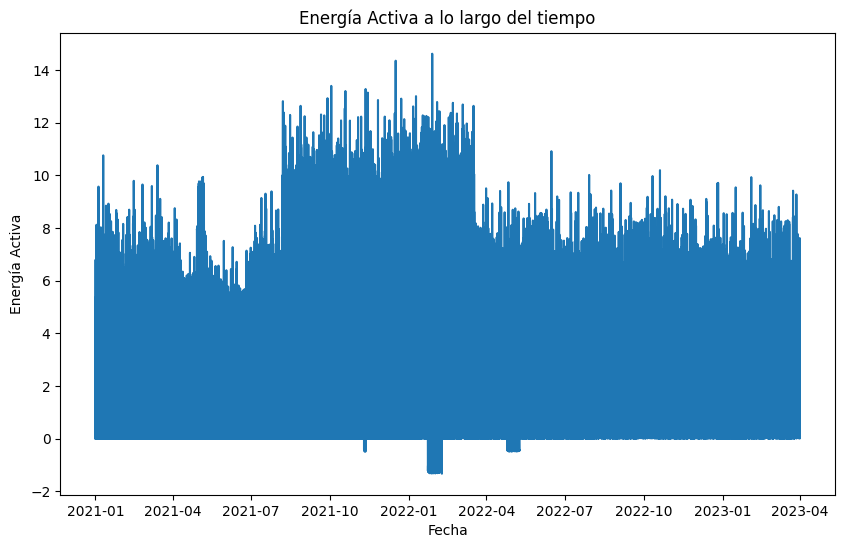

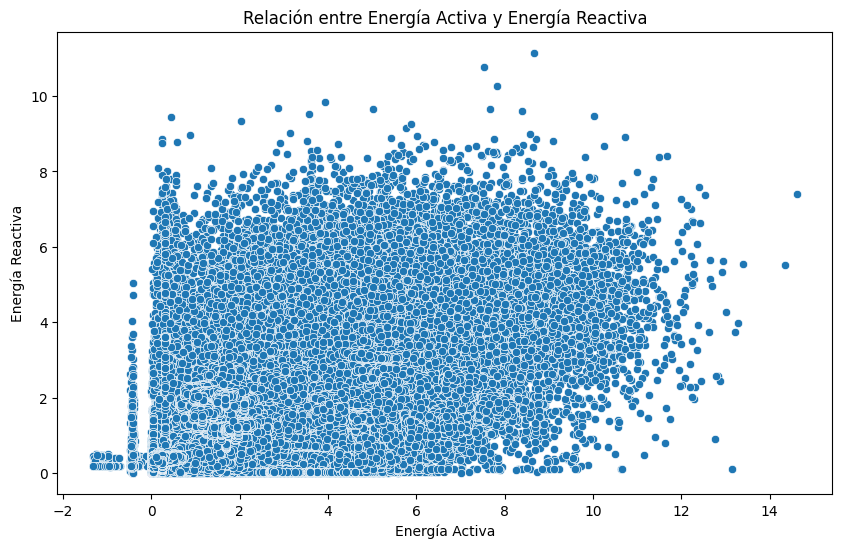

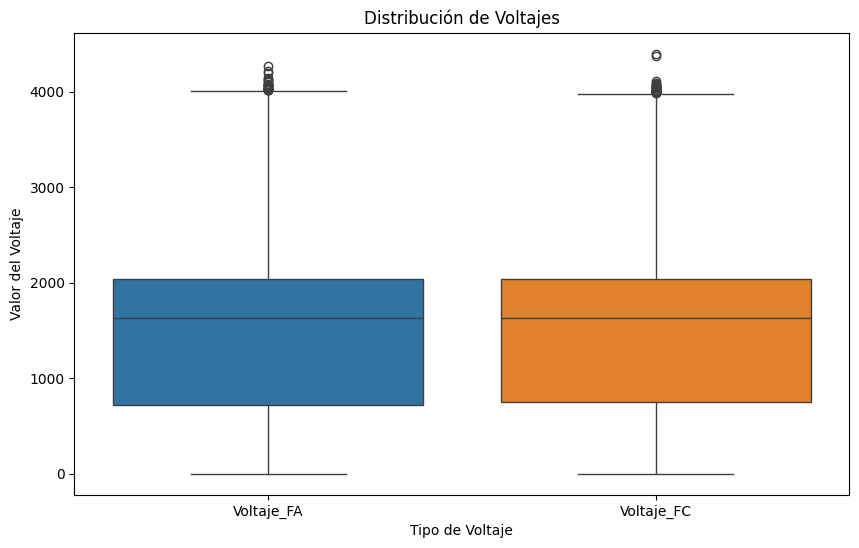

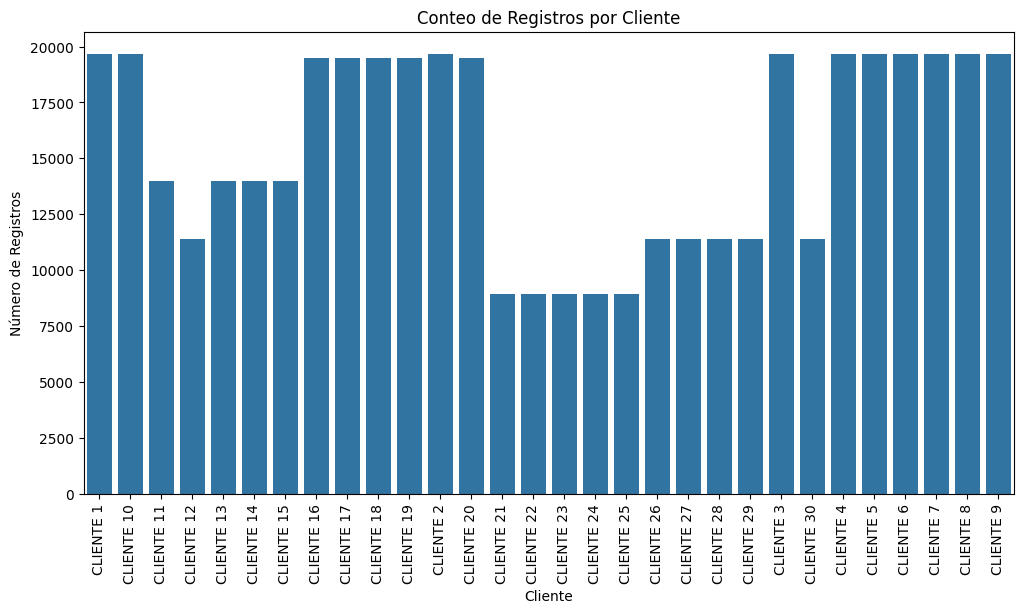

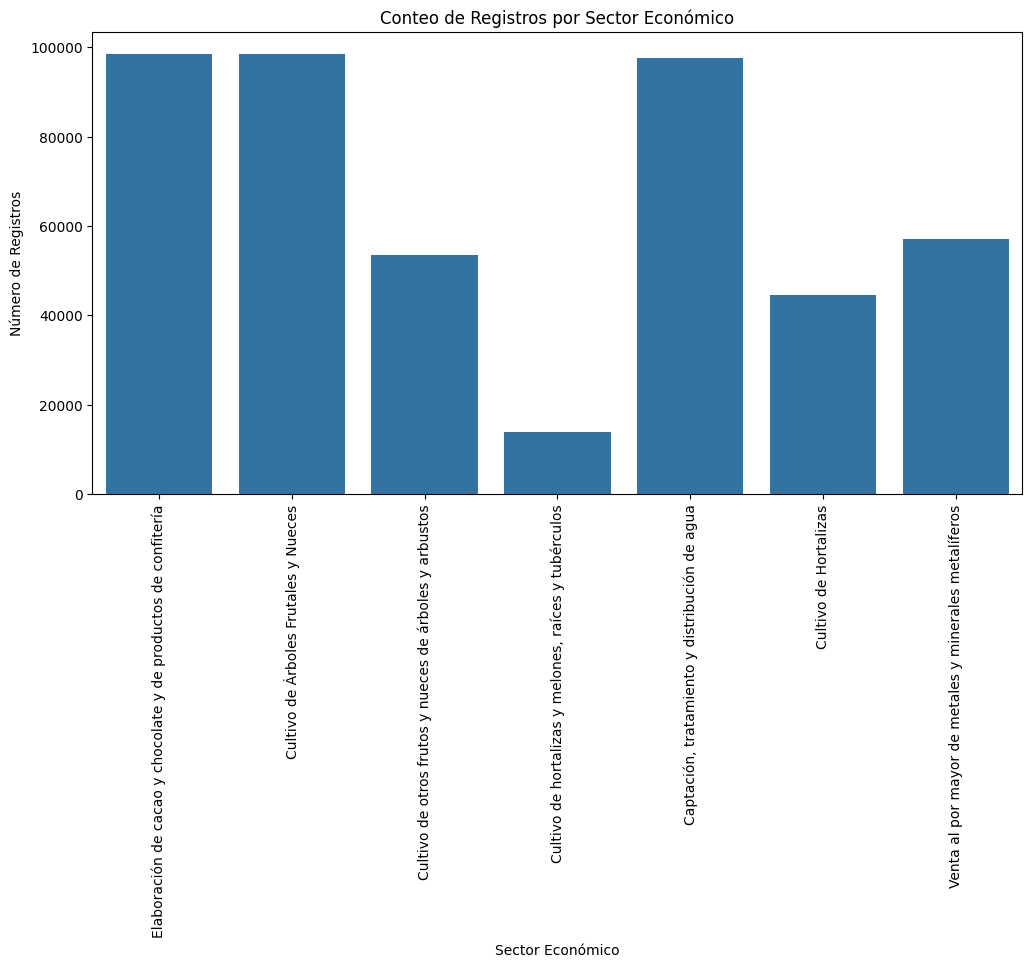

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico para la variable 'Fecha'
plt.figure(figsize=(10, 6))
plt.plot(df['Fecha'], df['Active_energy'])
plt.title('Energía Activa a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Energía Activa')
plt.show()

# Gráfico de dispersión para 'Active_energy' vs 'Reactive_energy'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Active_energy', y='Reactive_energy', data=df)
plt.title('Relación entre Energía Activa y Energía Reactiva')
plt.xlabel('Energía Activa')
plt.ylabel('Energía Reactiva')
plt.show()

# Boxplot para 'Voltaje_FA' y 'Voltaje_FC'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Voltaje_FA', 'Voltaje_FC']])
plt.title('Distribución de Voltajes')
plt.xlabel('Tipo de Voltaje')
plt.ylabel('Valor del Voltaje')
plt.show()

# Gráfico de barras para 'CLIENTE'
plt.figure(figsize=(12, 6))
sns.countplot(x='CLIENTE ', data=df)
plt.title('Conteo de Registros por Cliente')
plt.xlabel('Cliente')
plt.ylabel('Número de Registros')
plt.xticks(rotation=90)
plt.show()

# Gráfico de barras para 'Sector Económico'
plt.figure(figsize=(12, 6))
sns.countplot(x='Sector Económico:', data=df)
plt.title('Conteo de Registros por Sector Económico')
plt.xlabel('Sector Económico')
plt.ylabel('Número de Registros')
plt.xticks(rotation=90)
plt.show()


                 Active_energy  Reactive_energy  Voltaje_FA  Voltaje_FC
Active_energy         1.000000         0.641789   -0.240723   -0.239892
Reactive_energy       0.641789         1.000000   -0.150958   -0.158293
Voltaje_FA           -0.240723        -0.150958    1.000000    0.954814
Voltaje_FC           -0.239892        -0.158293    0.954814    1.000000


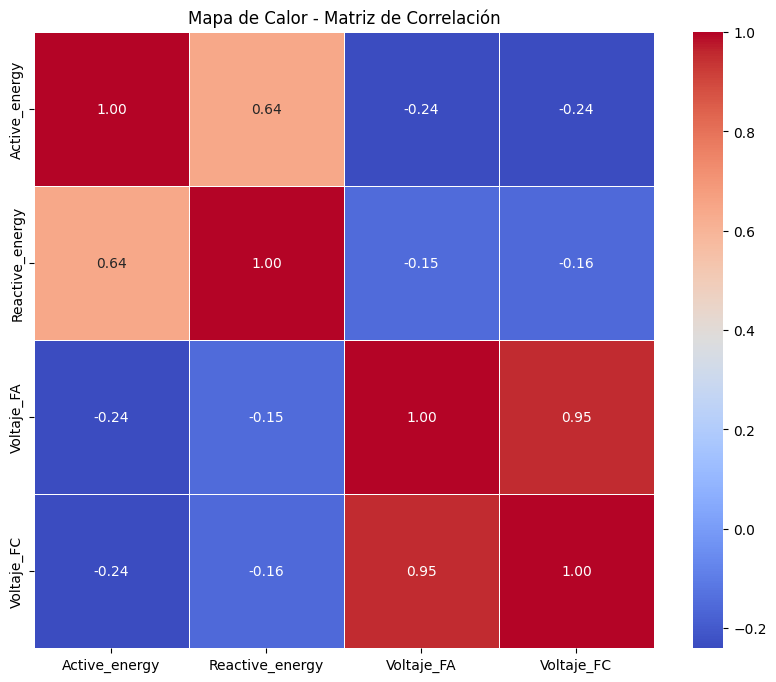

In [ ]:
# Selección de solo columnas numéricas
df_numeric = df.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()
print(correlation_matrix)

# Mapa de calor para la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor - Matriz de Correlación')
plt.show()


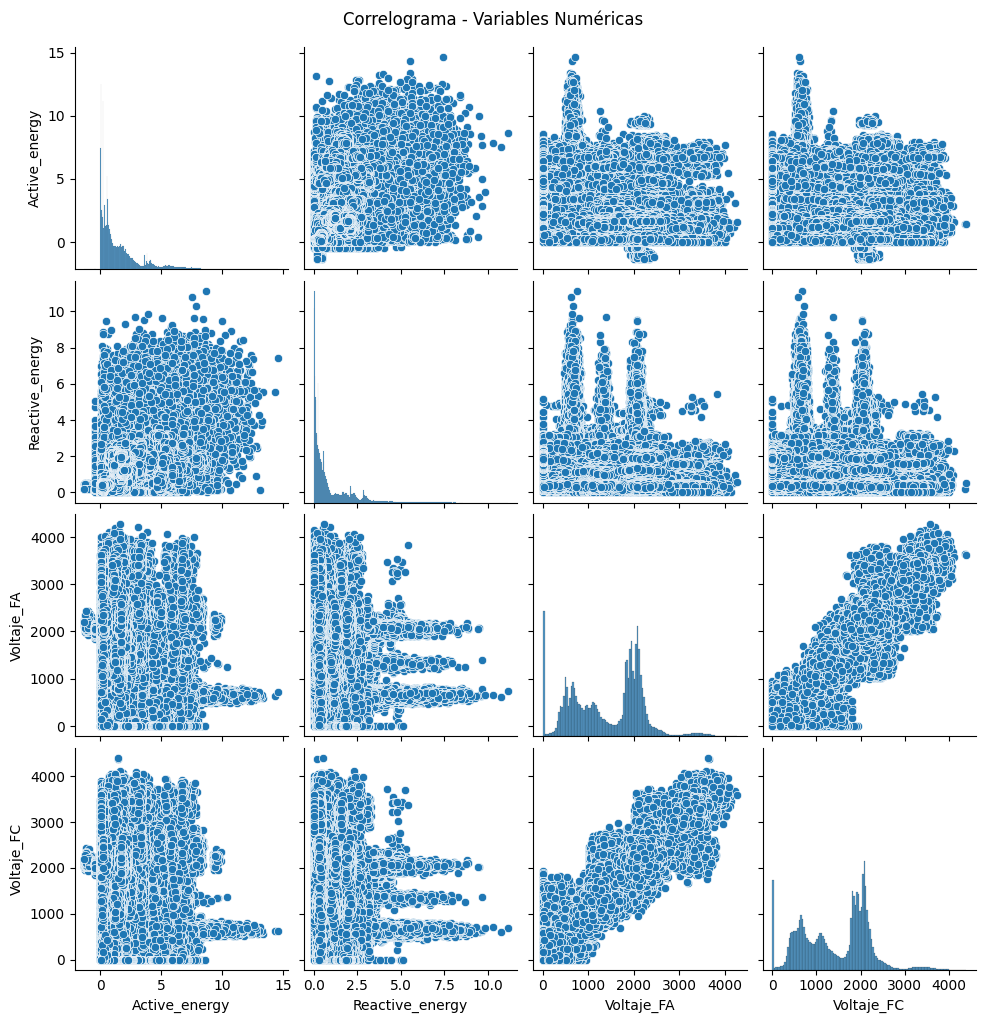

In [ ]:
# Correlograma (Pairplot) para variables numéricas
numeric_variables = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']
sns.pairplot(df[numeric_variables])
plt.suptitle('Correlograma - Variables Numéricas', y=1.02)
plt.show()

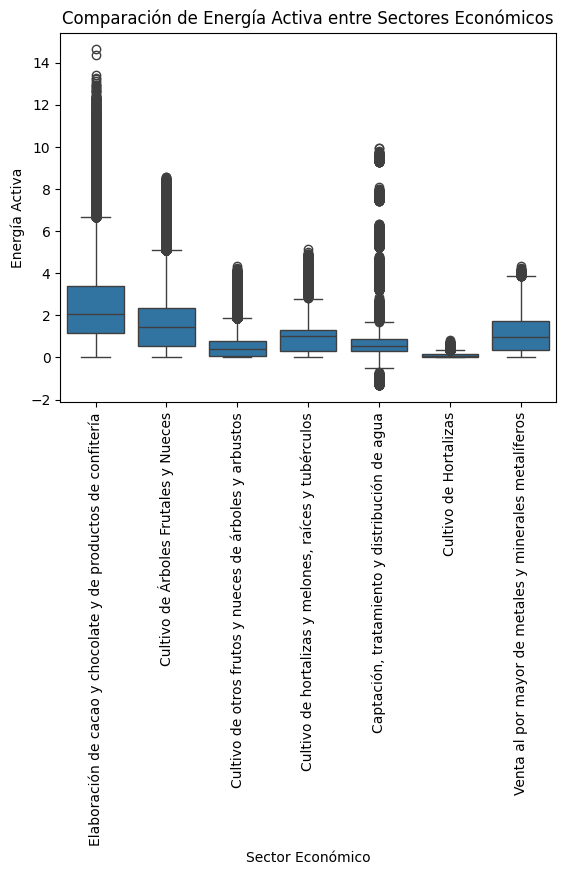

In [ ]:
# Boxplot comparativo entre sectores económicos y energía activa
sns.boxplot(x='Sector Económico:', y='Active_energy', data=df)
plt.xlabel('Sector Económico')
plt.ylabel('Energía Activa')
plt.title('Comparación de Energía Activa entre Sectores Económicos')
plt.xticks(rotation=90)
plt.show()

Con el fin de analizar la claridad de los datos se exploran las diferentes columnas mediante diferentes técnicas estadísticas con el fin de evaluar si estas generan resultados entendibles.

Primero, se realiza un análisis de estadísticas descriptivas básicas mediante la función “.describe()” de la librería pandas. Puede observarse entonces un cuadro resultante con las estadísticas descriptivas básicas en el dataframe, se observa que por ejemplo para la columna de energía activa existen 463425 registros, la media de la energía activa dentro de la base de datos es de 1.472050 con una desviación estándar de 1.718780 lo cuál nos da una idea de la variabilidad de los datos con respecto a su media, se encuentra un valor mínimo de energía activa de -1.329018 lo cuál evidencia la conclusión anterior sobre la inconsistencia de valores negativos dentro de la energía, la tabla también nos indica un valor máximo de energía activa de 14.622644 con percentiles del 25%, 50% y 75% con valores de 0.242788, 0.810771 y 1.992488 lo cual brinda una idea de la distribución de los valores de la energía activa alrededor de la base de datos, este mismo análisis estadístico es extensivo a las otras dimensiones numéricas.

Luego, se realizan diferentes visualizaciones básicas con el fin de corroborar la calidad de las dimensiones desde una perspectiva visual:


*   Se realiza un gráfico de series de tiempo con respecto al tiempo y la energía activa, acá puede evidenciasen anormalidades al finalizar 2021, alrededor de febrero de 2022 y alrededor de mayo de 2022 ya que pueden observarse valores de energía negativos.

*   Se realiza un gráfico de dispersión entre la energía activa y la energía reactiva, se observa un comportamiento disperso entre ámbas variables, sin aparentes patrones o formaciones de patrones en la gráfica y con el mismo análisis de elementos negativos atípicos dentro de la energía activa.

*   Se hacen boxplots para comparar la distribución de los tipos de voltajes, ambos parecen tener distribuciones de voltaje similares dentro de sus percentiles, pueden apreciarse valores atípicos de voltajes altos.

*   Se hace un conteo de registros por cliente mediante un gráfico de barras donde puede apreciarse el balance de registros por cliente, se puede apreciar como algunos clientes como el número 21 tienen alrededor de 8000 registros mientras otros el cliente 2 tienen alrededor de 20000 registros, esto debe considerarse particularmente al momento de hacer modelos de machine learning.

*   Similar al análisis del gráfico anterior se hace un conteo de registros por sector económico mediante gráficos de barras con el fin de explorar esta dimensión, puede apreciarse el desbalance con algunos sectores económicos, por ejemplo el cultivo de hortalizas, melones, raíces y tubérculos tiene alrededor de 17000 registros mientras que el cultivo de árboles frutales y nueces tiene alrededor de 98000 registros, al igual que se observó con el gráfico anterior, esto debe considerarse particularmente al momento de hacer modelos de machine learning.

Luego se realiza una matriz de correlación, un mapa de calor y un correlograma con el fin de analizar de forma gráfica los resultados de la matriz de correlación, pueden entonces apreciarse algunas relaciones lineales fuertes entre las variables, por ejemplo, los voltajes FA y FC tienen una alta correlación positiva con un valor de 0.95, también se aprecia una alta correlación positiva entre la energía reactiva y la energía activa con un valor de 0.64. Estos resultados pueden apreciarse gráficamente en el correlograma donde puede observarse la formación casi lineal entre estas variables.

Finalmente, se realizan boxplots con cada uno de los sectores económicos con respecto a la energía activa, puede observarse una alta variablidad en cuanto a la distribución de energía activa a lo largo de los percentiles según su sector, también se observa la presencia de valores atípicos con respecto a valores altos de energía activa en todas las categorías.


In [ ]:
print(df['Fecha'].min(), df['Fecha'].max())


**Formato**

Los datos ya han sido explorados desde mútiples perspectivas y puede concluirse en este aparte que el formato es correcto, los datos son coherentes para el estudio a realizar, los datos de fecha se encuentran en formato de datetime, los valores numérivos correspondientes a tipos de energía o voltajes son de tipo decimal mientras que los sectores y tipos de cliente corresponden a variables de tipo objeto ya que contienen cadenas de caracteres.

##Proceso de limpieza de datos

In [ ]:
#Se eliminan los registros con valores de energía negativos:
common_columns = set(df.columns) & set(negative_energy.columns)
df = pd.merge(df, negative_energy, on=list(common_columns), how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
df

,Source.Name,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,CLIENTE,Proper,Sector Económico:
0,DATOSCLIENTE1.csv,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,CLIENTE 1,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,DATOSCLIENTE1.csv,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,CLIENTE 1,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,DATOSCLIENTE1.csv,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,CLIENTE 1,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,DATOSCLIENTE1.csv,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,CLIENTE 1,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,DATOSCLIENTE1.csv,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,CLIENTE 1,Cliente 1,Elaboración de cacao y chocolate y de producto...
...,...,...,...,...,...,...,...,...,...
463420,DATOSCLIENTE9.csv,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,CLIENTE 9,Cliente 9,Cultivo de Árboles Frutales y Nueces
463421,DATOSCLIENTE9.csv,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,CLIENTE 9,Cliente 9,Cultivo de Árboles Frutales y Nueces
463422,DATOSCLIENTE9.csv,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,CLIENTE 9,Cliente 9,Cultivo de Árboles Frutales y Nueces
463423,DATOSCLIENTE9.csv,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,CLIENTE 9,Cliente 9,Cultivo de Árboles Frutales y Nueces


In [ ]:
#Se eliminan columnas redundantes y se resetea el index
df = df.drop(['Source.Name','CLIENTE ' ], axis=1)
df = df.reset_index(drop=True)
df

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Proper,Sector Económico:
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...
...,...,...,...,...,...,...,...
462915,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,Cliente 9,Cultivo de Árboles Frutales y Nueces
462916,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,Cliente 9,Cultivo de Árboles Frutales y Nueces
462917,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,Cliente 9,Cultivo de Árboles Frutales y Nueces
462918,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,Cliente 9,Cultivo de Árboles Frutales y Nueces


In [ ]:
#Se renombras las columnas
# Se crea un diccionario de mapeo para los nuevos nombres de las columnas
nuevos_nombres = {'Active_energy': 'Energía_Activa', 'Reactive_energy': 'Energía_Reactiva','Proper': 'Cliente', 'Sector Económico:': 'Sector Económico',}
# Se renombrar las columnas utilizando el método rename
df.rename(columns=nuevos_nombres, inplace=True)
df

,Fecha,Energía_Activa,Energía_Reactiva,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...
...,...,...,...,...,...,...,...
462915,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,Cliente 9,Cultivo de Árboles Frutales y Nueces
462916,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,Cliente 9,Cultivo de Árboles Frutales y Nueces
462917,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,Cliente 9,Cultivo de Árboles Frutales y Nueces
462918,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,Cliente 9,Cultivo de Árboles Frutales y Nueces


Para el proceso de limpieza de datos, se comienza por eliminar los registros con valores negativos de energía hallados en el proceso anterior ya que no tiene sentido tener valores de energía negativa en nuestra base de datos, así se eliminan 505 registros.

Luego, se puede observar que hay columnas redundantes ya que  'Source.Name', 'CLIENTE ' y ‘Proper’ hacen referencia a los mismos datos (identificador del cliente), por lo cuál se eliminan las columnas 'Source.Name' y 'CLIENTE ' conservando solo ‘Proper’ ya que es la que conserva el nombre de los clientes de una forma visual y gramatical más adecuada, también en este paso se resetea el index del dataframe con el fin de tener ids ordenados según nuestro número total de registros.

Finalmente, se renombran las etiquetas de las columnas ya que algunas estaban en español y otras en inglés, se pasa todo a español con el fin de generar mayor armonía en la base de datos.


##Proceso de entendimiento de datos

**cálculo de eficiencia energetica**

In [ ]:
def calcular_eficiencia_energetica(registro):
    energia_activa = registro["Energía_Activa"]
    energia_reactiva = registro["Energía_Reactiva"]

    # Calcula la potencia aparente
    potencia_aparente = energia_activa + energia_reactiva

    # Verifica si la potencia aparente es cero para evitar la división por cero
    if potencia_aparente != 0:
        eficiencia_energetica = (energia_activa / potencia_aparente) * 100
    else:
        eficiencia_energetica = 0

    return eficiencia_energetica

In [ ]:
# Calcula la eficiencia energética de cada registro
eficiencia_energetica = []
for registro in df.iterrows():
    eficiencia_energetica.append(calcular_eficiencia_energetica(registro[1]))

df['eficiencia_energetica'] = eficiencia_energetica

**Eficiencia energética = (Energía activa / Potencia aparente) * 100**

En esta fórmula, la energía activa es la energía que se utiliza para realizar un trabajo útil, mientras que la potencia aparente es la potencia total que se consume.


La eficiencia energética es una variable importante que debemos calcular y añadir a nuestro proyecto porque nos permite evaluar el desempeño energético de los clientes e identificar oportunidades de mejora.


La eficiencia energética mide la relación entre la energía activa consumida y la potencia aparente consumida. La energía activa es la energía que se utiliza para realizar un trabajo útil, mientras que la potencia aparente es la potencia total que se consume.


Un cliente con una eficiencia energética alta es aquel que consume menos energía para realizar un trabajo útil. Esto significa que el cliente está utilizando su energía de manera más eficiente, lo que puede reducir sus costes energéticos y su impacto ambiental.

La eficiencia energética es una variable importante para nuestro proyecto porque nos permite:

- Comparar el desempeño energético de diferentes clientes. Esto nos puede ayudar a identificar clientes con una eficiencia energética baja, que podrían ser candidatos para programas de eficiencia energética.

- Identificar oportunidades de mejora en la eficiencia energética. Esto nos puede ayudar a desarrollar programas de eficiencia energética que sean efectivos y que tengan un impacto positivo en los clientes y en la empresa.

**Energía Total Consumida**

In [ ]:
def calcular_energia_total_consumida(registro):
    energia_activa = registro["Energía_Activa"]
    energia_reactiva = registro["Energía_Reactiva"]

    energia_total_consumida = energia_activa + energia_reactiva

    return energia_total_consumida

In [ ]:
# Calcula la energía total consumida de cada registro
energia_total_consumida = []
for registro in df.iterrows():
    energia_total_consumida.append(calcular_energia_total_consumida(registro[1]))

df['energia_total_consumida'] = energia_total_consumida

La energía total consumida se calcula sumando la energía activa consumida y la energía reactiva consumida. La energía activa es la energía que se utiliza para realizar un trabajo útil, mientras que la energía reactiva es la energía que se utiliza para crear un campo magnético.

Para calcular la energía total consumida, podemos utilizar la siguiente fórmula:

**Energía total consumida = Energía activa consumida + Energía reactiva consumida**

La energía total consumida es una variable importante que debemos calcular y añadir a nuestro proyecto porque nos permite:

- Comparar el consumo de energía de diferentes clientes. Esto nos puede ayudar a identificar clientes con un consumo de energía alto, que podrían ser candidatos para programas de eficiencia energética.
- Identificar tendencias en el consumo de energía. Esto nos puede ayudar a planificar la capacidad de la red eléctrica y a desarrollar políticas energéticas.
- Evaluar el impacto ambiental de la empresa. El consumo de energía es una de las principales fuentes de emisiones de gases de efecto invernadero.


**Calidad de la energía**

In [ ]:
# Calculando el Factor de Potencia (FP)
df['Energía_Aparente'] = df['Energía_Activa']**2 + df['Energía_Reactiva']**2
df['Factor_de_Potencia'] = df['Energía_Activa'] / df['Energía_Aparente']

# Calculando la Desviación de Voltaje
df['Desviación_Voltaje'] = abs(df['Voltaje_FA'] - df['Voltaje_FC'])

# Agrupando por cliente y calculando los valores promedio por cliente
resultados_por_cliente = df.groupby('Cliente').agg({
    'Factor_de_Potencia': 'mean',
    'Desviación_Voltaje': 'mean'
}).reset_index()

# Imprimiendo los resultados por cliente
print(resultados_por_cliente)


       Cliente  Factor_de_Potencia  Desviación_Voltaje
0    Cliente 1            0.662030           47.848932
1   Cliente 10            0.349064          139.134524
2   Cliente 11            5.868753           37.939068
3   Cliente 12            0.897496           92.779426
4   Cliente 13            3.714082           86.727431
5   Cliente 14            5.681399           36.059843
6   Cliente 15            2.071874           36.059843
7   Cliente 16            1.580623           41.996960
8   Cliente 17            1.291950           83.082479
9   Cliente 18            1.061163           87.572209
10  Cliente 19            1.128700           36.732393
11   Cliente 2            0.269072           94.824363
12  Cliente 20            0.403039           36.699131
13  Cliente 21            8.356660          165.391140
14  Cliente 22            3.187110          218.513852
15  Cliente 23            1.935506          227.094555
16  Cliente 24            5.119519          175.339837
17  Client

####Segmentar los datos y encontrar agrupaciones:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462920 entries, 0 to 462919
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Fecha                    462920 non-null  datetime64[ns]
 1   Energía_Activa           462920 non-null  float64       
 2   Energía_Reactiva         462920 non-null  float64       
 3   Voltaje_FA               462920 non-null  float64       
 4   Voltaje_FC               462920 non-null  float64       
 5   Cliente                  462920 non-null  object        
 6   Sector Económico         462920 non-null  object        
 7   eficiencia_energetica    462920 non-null  float64       
 8   energia_total_consumida  462920 non-null  float64       
 9   Energía_Aparente         462920 non-null  float64       
 10  Factor_de_Potencia       447907 non-null  float64       
 11  Desviación_Voltaje       462920 non-null  float64       
dtypes: datetime64[ns

In [ ]:
def k_means(df, k):
    # Inicializa el modelo de clusterización
    modelo = KMeans(n_clusters=k)

    # Entrena el modelo
    modelo.fit(df[['energia_total_consumida', 'eficiencia_energetica']])

    # Obtiene los grupos de datos
    grupos = modelo.predict(df[['energia_total_consumida', 'eficiencia_energetica']])

    return grupos


grupos = k_means(df.copy(), 4)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


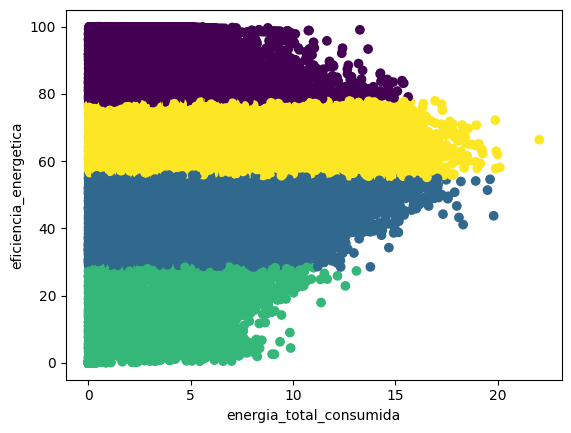

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df["energia_total_consumida"], df["eficiencia_energetica"], c=grupos)
plt.xlabel("energia_total_consumida")
plt.ylabel("eficiencia_energetica")
plt.show()

Para llevar a cabo la segmentación de datos, se ha optado por la implementación de un modelo de clusterización conocido como KMeans. Este modelo posibilita la agrupación de datos según sus similitudes. En este escenario, se emplearán dos variables previamente calculadas: la energía total consumida y la eficiencia energética. La elección de estas variables apunta a identificar agrupaciones que compartan niveles similares de consumo de energía y eficiencia.



La determinación del número de grupos se basará en la magnitud de los datos y en los objetivos específicos del análisis. En el contexto del proyecto de Electro Dunas, el propósito central radica en identificar oportunidades de mejora en la eficiencia energética de los clientes. Tras evaluar los resultados de las posibles agrupaciones, se ha establecido que el número óptimo de clústers es 4, lo que representa segmentos que contienen aproximadamente el 25% de los registros totales.

#Modelos

###Descripción Estadística Básica

In [ ]:
df

,Fecha,Energía_Activa,Energía_Reactiva,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico,eficiencia_energetica,energia_total_consumida,Energía_Aparente,Factor_de_Potencia,Desviación_Voltaje
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...,55.857724,0.640629,0.208019,1.720229,55.421831
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...,46.322173,0.803642,0.324667,1.146603,0.061610
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...,75.520676,1.383312,1.206038,0.866214,78.228027
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...,53.324797,1.062216,0.566646,0.999609,8.206266
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...,69.597704,1.552575,1.390403,0.777153,21.986123
...,...,...,...,...,...,...,...,...,...,...,...,...
462915,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,Cliente 9,Cultivo de Árboles Frutales y Nueces,42.738747,0.540493,0.149147,1.548807,54.791156
462916,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,Cliente 9,Cultivo de Árboles Frutales y Nueces,11.779110,0.356027,0.100412,0.417650,215.900367
462917,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,Cliente 9,Cultivo de Árboles Frutales y Nueces,46.391365,0.497937,0.124617,1.853685,113.726457
462918,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,Cliente 9,Cultivo de Árboles Frutales y Nueces,32.472314,0.462843,0.120275,1.249606,192.764929


In [ ]:
df.columns

Index(['Fecha', 'Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA',
       'Voltaje_FC', 'Cliente', 'Sector Económico', 'eficiencia_energetica',
       'energia_total_consumida', 'Energía_Aparente', 'Factor_de_Potencia',
       'Desviación_Voltaje'],
      dtype='object')

In [ ]:
# Iniciar el tiempo de ejecución
start_time = time.time()

# Realizar la descripción estadística del dataframe y transponer el resultado
df_std = df.describe().T

# Finalizar el tiempo de ejecución y calcular la duración
end_time = time.time()
duration = end_time - start_time

print(df_std)  # Mostrar el resultado transpuesto
print(f"Tiempo de ejecución del script: {duration} segundos")


                            count                           mean  \
Fecha                      462920  2021-12-14 18:54:48.682277888   
Energía_Activa           462920.0                       1.474491   
Energía_Reactiva         462920.0                        0.87346   
Voltaje_FA               462920.0                    1419.424795   
Voltaje_FC               462920.0                     1437.78286   
eficiencia_energetica    462920.0                      59.965814   
energia_total_consumida  462920.0                       2.347951   
Energía_Aparente         462920.0                       7.232596   
Factor_de_Potencia       447907.0                       1.769533   
Desviación_Voltaje       462920.0                     123.744181   

                                         min                  25%  \
Fecha                    2021-01-01 00:00:00  2021-06-10 17:00:00   
Energía_Activa                           0.0             0.244981   
Energía_Reactiva                         0.0

- La energía activa promedio es de 1.474491 kWh, con una desviación estándar de 1.718085 kWh. Esto significa que la mayoría de los valores de energía activa se encuentran entre 1.244981 kWh y 1.994143 kWh. El valor mínimo es de 0 kWh, lo que indica que en algunos casos no se consumió energía activa.

- La energía reactiva promedio es de 0.873460 kWh, con una desviación estándar de 1.159194 kWh. Esto significa que la mayoría de los valores de energía reactiva se encuentran entre 0.112592 kWh y 1.224194 kWh. El valor mínimo es de 0 kWh, lo que indica que en algunos casos no se consumió energía reactiva.

- El voltaje promedio en la fase A es de 1419.424795 V, con una desviación estándar de 766.361982 V. Esto significa que la mayoría de los valores de voltaje en la fase A se encuentran entre 718.894696 V y 2036.493964 V. El valor mínimo es de 0.031 V, lo que indica que en algunos casos el voltaje en la fase A fue muy bajo.

- El voltaje promedio en la fase B es de 1437.782860 V, con una desviación estándar de 746.518650 V. Esto significa que la mayoría de los valores de voltaje en la fase B se encuentran entre 747.500206 V y 2039.985717 V. El valor mínimo es de 0.031 V, lo que indica que en algunos casos el voltaje en la fase B fue muy bajo.

- La eficiencia energética promedio es de 59.965814 %, con una desviación estándar de 24.859382 %. Esto significa que la mayoría de los valores de eficiencia energética se encuentran entre 47.995294 % y 78.735243 %. El valor mínimo es de 0 %, lo que indica que en algunos casos la eficiencia energética fue muy baja.

- La energía total consumida promedio es de 2.347951 kWh, con una desviación estándar de 2.617838 kWh. Esto significa que la mayoría de los valores de energía total consumida se encuentran entre 0.495856 kWh y 3.282312 kWh. El valor mínimo es de 0 kWh, lo que indica que en algunos casos no se consumió energía total.

- La energía aparente promedio es de 7.232596 kVA, con una desviación estándar de 15.029982 kVA. Esto significa que la mayoría de los valores de energía aparente se encuentran entre 0.152199 kVA y 6.551441 kVA. El valor mínimo es de 0 kVA, lo que indica que en algunos casos no se consumió energía aparente.

- El factor de potencia promedio es de 1.769533, con una desviación estándar de 4.011231. Esto significa que la mayoría de los valores de factor de potencia se encuentran entre 0.273082 y 2.756149. El valor mínimo es de 0.000262, lo que indica que en algunos casos el factor de potencia fue muy bajo.

- La desviación de voltaje promedio es de 123.744181 V, con una desviación estándar de 192.765173 V. Esto significa que la mayoría de los valores de desviación de voltaje se encuentran entre 26.817268 V y 1938.027309 V. El valor mínimo es de 0 V, lo que indica que en algunos casos la desviación de voltaje fue muy baja.



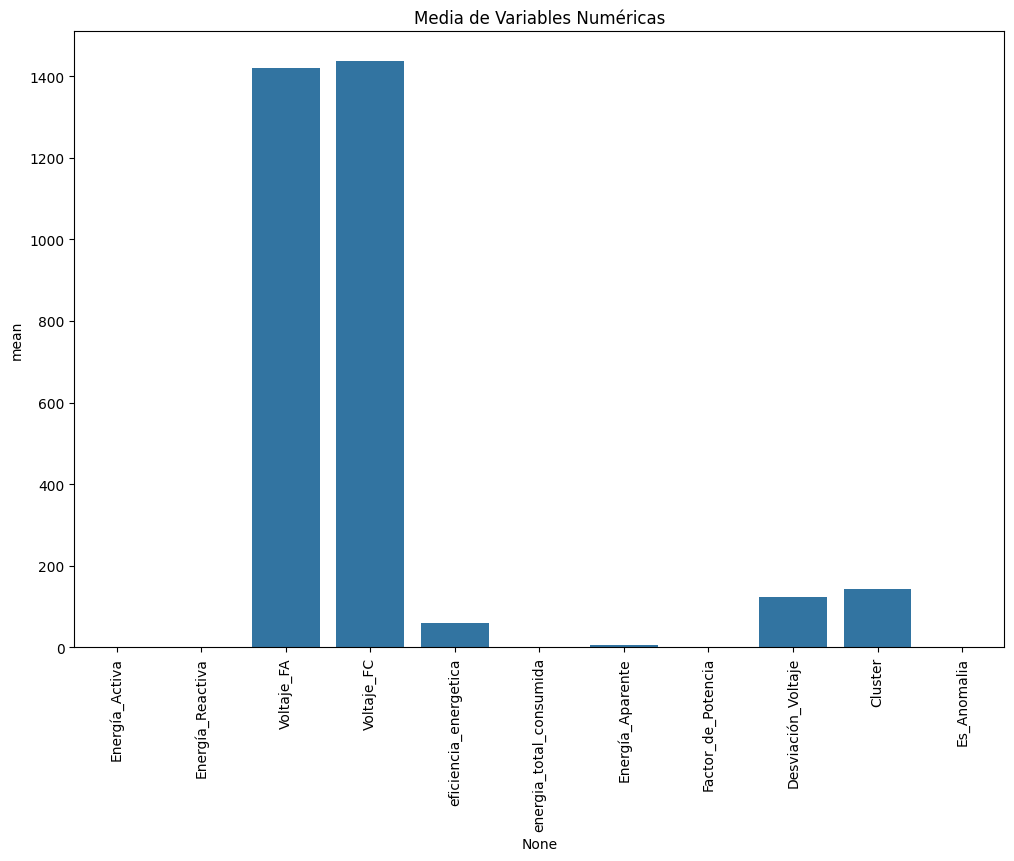

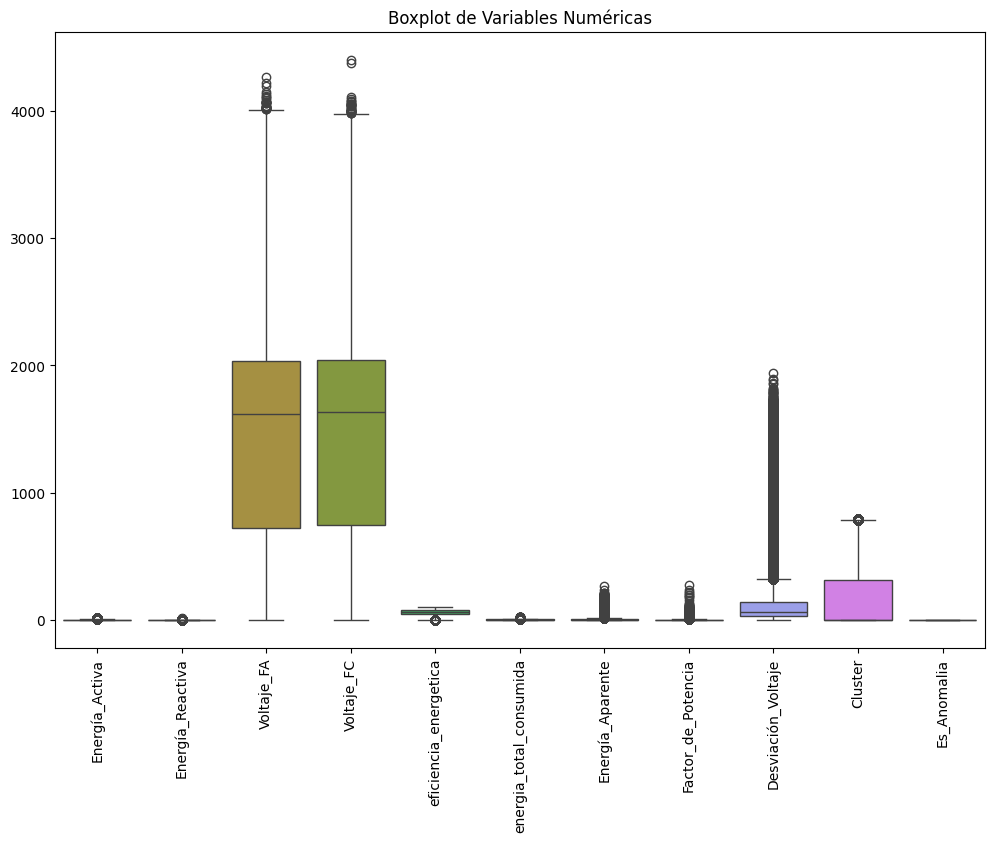

In [ ]:

# Excluir columnas no numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Generar estadísticas descriptivas para columnas numéricas
stats = df_numeric.describe().T

# Gráficos de barras para las medias de las columnas numéricas
plt.figure(figsize=(12, 8))
sns.barplot(x=stats.index, y=stats['mean'])
plt.xticks(rotation=90)
plt.title('Media de Variables Numéricas')
plt.show()

# Boxplot para visualizar las distribuciones
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_numeric)
plt.xticks(rotation=90)
plt.title('Boxplot de Variables Numéricas')
plt.show()


In [ ]:
# Segmentar por días y agrupar los datos
df_por_dia = df.groupby(df['Cliente']).agg({'energia_total_consumida': 'sum', 'eficiencia_energetica': 'mean'})

df_por_dia

,energia_total_consumida,eficiencia_energetica
Cliente,,
Cliente 1,56609.026024,66.150617
Cliente 10,84219.634820,83.400819
Cliente 11,11479.687235,88.051907
Cliente 12,22027.395163,57.198617
Cliente 13,16013.737958,77.715926
Cliente 14,3648.743940,61.129047
Cliente 15,10924.565171,55.189441
Cliente 16,42293.954681,53.457403
Cliente 17,45437.823155,51.410096


In [ ]:
df_por_dia = df.groupby(df['Sector Económico']).agg({'energia_total_consumida': 'sum', 'eficiencia_energetica': 'mean'})

df_por_dia

,energia_total_consumida,eficiencia_energetica
Sector Económico,,
"Captación, tratamiento y distribución de agua",243771.763400,48.197765
Cultivo de Hortalizas,10348.583998,36.396475
"Cultivo de hortalizas y melones, raíces y tubérculos",16013.737958,77.715926
Cultivo de otros frutos y nueces de árboles y arbustos,48080.391509,65.788781
Cultivo de Árboles Frutales y Nueces,244241.101620,68.993047
Elaboración de cacao y chocolate y de productos de confitería,427716.858766,63.450788
Venta al por mayor de metales y minerales metalíferos,96740.986639,67.016614


Estos resultados muestran la cantidad total de energía consumida y la eficiencia energética promedio en diferentes sectores económicos.

- Captación, tratamiento y distribución de agua: Este sector ha consumido una considerable cantidad de energía, indicando la demanda energética asociada a las operaciones de tratamiento y distribución de agua. La eficiencia energética, aunque no es la más alta en comparación con otros sectores, aún muestra una eficiencia razonable en el uso de la energía.

- Cultivo de Hortalizas: El consumo de energía en este sector es menor en comparación con otros, lo que podría deberse a la naturaleza de las actividades agrícolas. La eficiencia energética parece estar en el rango medio.

- Cultivo de hortalizas y melones, raíces y tubérculos: Similar al cultivo de hortalizas, el consumo de energía es moderado, pero la eficiencia energética es considerablemente alta en este caso, posiblemente debido a prácticas más eficientes en el manejo de energía.

- Cultivo de otros frutos y nueces de árboles y arbustos: Este sector tiene un consumo de energía moderado con una eficiencia energética razonablemente alta, lo que sugiere prácticas más eficientes en comparación con otros sectores agrícolas.

- Cultivo de Árboles Frutales y Nueces: Muestra un alto consumo de energía, probablemente debido a las demandas energéticas asociadas con la agricultura intensiva. A pesar del alto consumo, la eficiencia energética es relativamente alta, lo que puede ser indicativo de prácticas más eficientes en el uso de la energía en este sector.

- Elaboración de cacao y chocolate y de productos de confitería: Presenta un alto consumo de energía, lo que es comprensible debido a las demandas energéticas en los procesos de elaboración. La eficiencia energética es razonablemente alta, lo que sugiere un manejo relativamente eficiente de la energía.

- Venta al por mayor de metales y minerales metalíferos: Este sector muestra un consumo de energía considerable, probablemente debido a las operaciones intensivas asociadas con la manipulación y el procesamiento de metales. La eficiencia energética es alta, lo que indica una gestión efectiva de la energía a pesar del alto consumo.

En general, se observa una variabilidad en el consumo de energía y la eficiencia energética entre los diferentes sectores, lo que sugiere diferentes necesidades y prácticas en la gestión de energía en cada uno.

In [ ]:
df.columns

Index(['Fecha', 'Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA',
       'Voltaje_FC', 'Cliente', 'Sector Económico', 'eficiencia_energetica',
       'energia_total_consumida', 'Energía_Aparente', 'Factor_de_Potencia',
       'Desviación_Voltaje'],
      dtype='object')

In [ ]:

# Aplicando One Hot Encoding a la columna 'Sector Económico'
df_encoded = pd.get_dummies(df, columns=['Sector Económico'])

# Mostrando las primeras filas del DataFrame resultante para verificar los cambios
df_encoded


,Fecha,Energía_Activa,Energía_Reactiva,Voltaje_FA,Voltaje_FC,Cliente,eficiencia_energetica,energia_total_consumida,Energía_Aparente,Factor_de_Potencia,Desviación_Voltaje,"Sector Económico_Captación, tratamiento y distribución de agua",Sector Económico_Cultivo de Hortalizas,"Sector Económico_Cultivo de hortalizas y melones, raíces y tubérculos",Sector Económico_Cultivo de otros frutos y nueces de árboles y arbustos,Sector Económico_Cultivo de Árboles Frutales y Nueces,Sector Económico_Elaboración de cacao y chocolate y de productos de confitería,Sector Económico_Venta al por mayor de metales y minerales metalíferos
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,55.857724,0.640629,0.208019,1.720229,55.421831,False,False,False,False,False,True,False
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,46.322173,0.803642,0.324667,1.146603,0.061610,False,False,False,False,False,True,False
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,75.520676,1.383312,1.206038,0.866214,78.228027,False,False,False,False,False,True,False
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,53.324797,1.062216,0.566646,0.999609,8.206266,False,False,False,False,False,True,False
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,69.597704,1.552575,1.390403,0.777153,21.986123,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462915,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,Cliente 9,42.738747,0.540493,0.149147,1.548807,54.791156,False,False,False,False,True,False,False
462916,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,Cliente 9,11.779110,0.356027,0.100412,0.417650,215.900367,False,False,False,False,True,False,False
462917,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,Cliente 9,46.391365,0.497937,0.124617,1.853685,113.726457,False,False,False,False,True,False,False
462918,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,Cliente 9,32.472314,0.462843,0.120275,1.249606,192.764929,False,False,False,False,True,False,False


In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462920 entries, 0 to 462919
Data columns (total 18 columns):
 #   Column                                                                          Non-Null Count   Dtype         
---  ------                                                                          --------------   -----         
 0   Fecha                                                                           462920 non-null  datetime64[ns]
 1   Energía_Activa                                                                  462920 non-null  float64       
 2   Energía_Reactiva                                                                462920 non-null  float64       
 3   Voltaje_FA                                                                      462920 non-null  float64       
 4   Voltaje_FC                                                                      462920 non-null  float64       
 5   Cliente                                                          

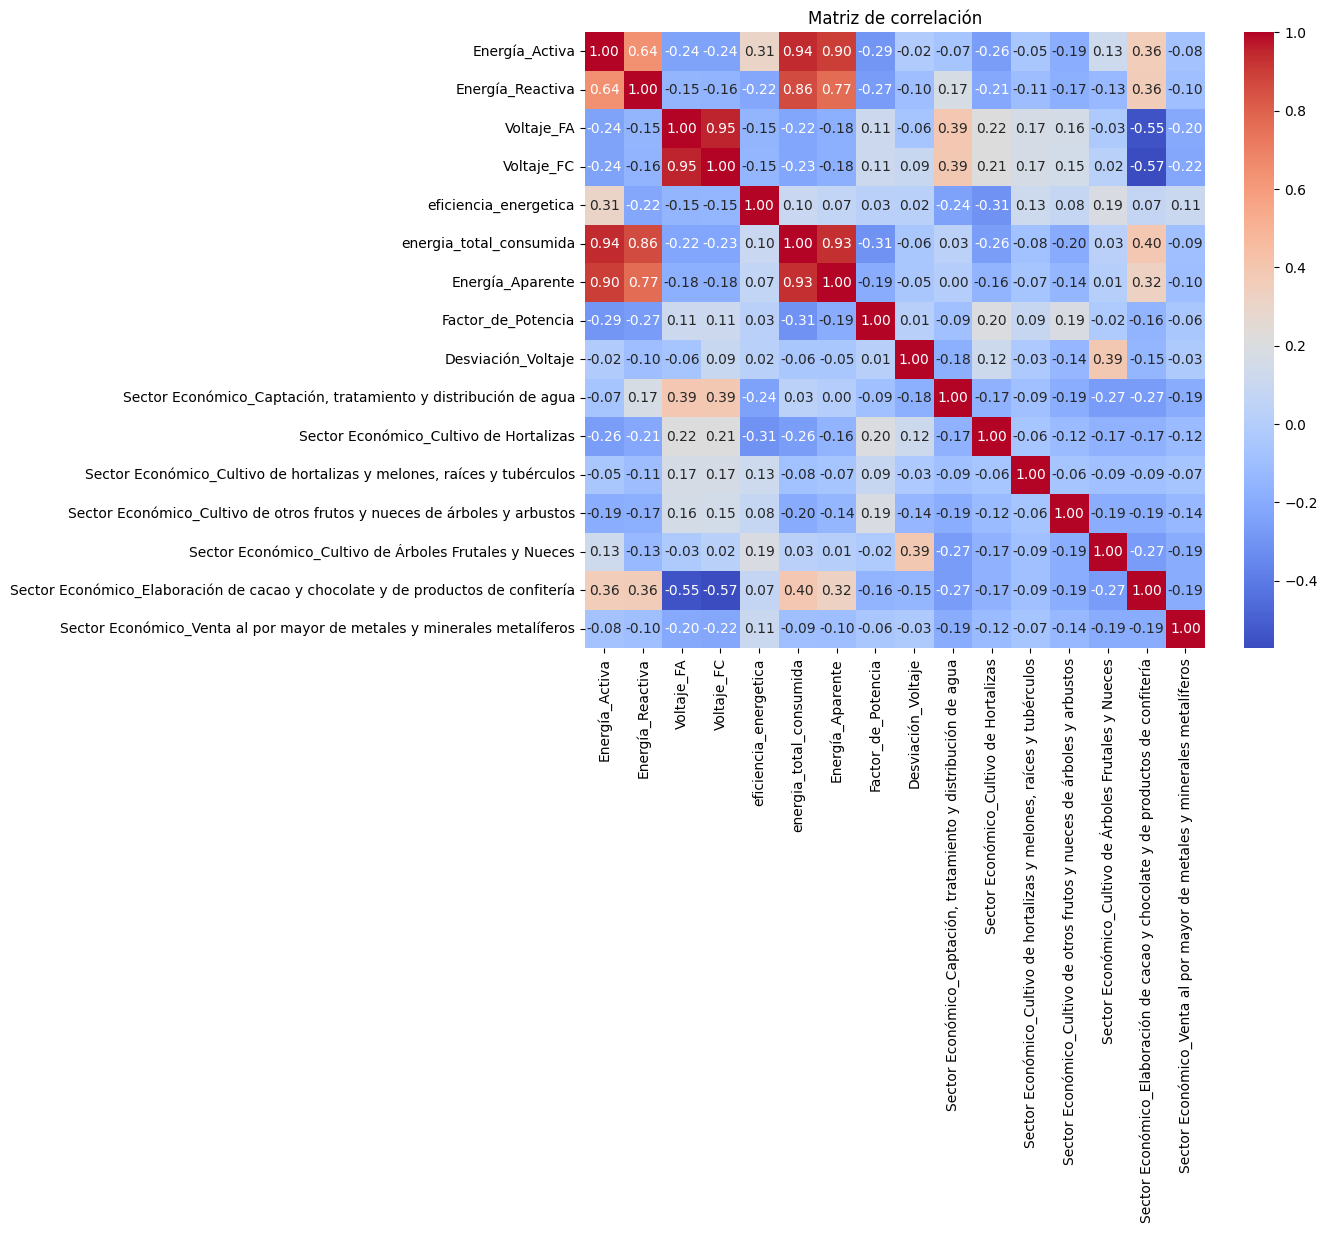

Tiempo de ejecución del script: 1.6765892505645752 segundos


In [ ]:


# Iniciar el tiempo de ejecución
start_time = time.time()

# Seleccionar solo las columnas numéricas
numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64', 'bool'])

# Calcular la matriz de correlación
correlation_matrix = numeric_cols.corr()

# Crear un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')

# Mostrar el mapa de calor
plt.show()

# Finalizar el tiempo de ejecución y calcular la duración
end_time = time.time()
duration = end_time - start_time

print(f"Tiempo de ejecución del script: {duration} segundos")



In [ ]:
#De copia un dataframe con menos columnas para el análisis de DBSCAN
df2 = df[['Fecha', 'Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA','Voltaje_FC']].copy()
df2

,Fecha,Energía_Activa,Energía_Reactiva,Voltaje_FA,Voltaje_FC
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719
...,...,...,...,...,...
462915,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372
462916,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989
462917,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378
462918,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710


In [ ]:
df.columns

Index(['Fecha', 'Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA',
       'Voltaje_FC', 'Cliente', 'Sector Económico'],
      dtype='object')

In [ ]:

# Asumiendo que 'Fecha' es una columna en df con tipo datetime
df2['Fecha_corta'] = df2['Fecha'].dt.date  # Crear la nueva columna en df

# Convertir la columna 'Fecha_corta' a tipo datetime
df2['Fecha_corta'] = pd.to_datetime(df2['Fecha_corta'])

# Asegurándonos de que todas las operaciones se realizan sobre el mismo DataFrame
df2 = df2.groupby('Fecha_corta').agg({
    'Energía_Activa': 'sum',
    'Energía_Reactiva': 'sum',
    'Voltaje_FA': 'mean',
    'Voltaje_FC': 'mean'
}).reset_index()


In [ ]:
#Se crea un dataframe con un enfoque que relaciones 1 observación al día vs 24 (1 por cada hora) esto con el fin de compactar el cóigo para los análisis de clustering
df2

,Fecha_corta,Energía_Activa,Energía_Reactiva,Voltaje_FA,Voltaje_FC
0,2021-01-01,792.554394,567.520550,1475.203016,1465.961828
1,2021-01-02,830.433269,574.908080,1442.373531,1456.602913
2,2021-01-03,831.038542,600.783535,1432.885729,1434.103765
3,2021-01-04,827.143279,588.552008,1446.012791,1449.758608
4,2021-01-05,754.070047,528.601552,1464.786706,1453.485634
...,...,...,...,...,...
816,2023-03-28,445.189565,228.411447,810.287218,897.672180
817,2023-03-29,433.675223,247.380164,886.717742,970.068074
818,2023-03-30,415.319802,237.542330,926.324487,1041.368404
819,2023-03-31,405.161205,235.698542,913.326345,1027.276222


In [ ]:

# Asegurar tipos de datos adecuados para optimizar memoria
for col in ['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']:
    df2[col] = df2[col].astype('float32')

# Seleccionar columnas para el análisis
columnas_para_escalar = ['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']

df2_analisis = df2[columnas_para_escalar]

# Normalizar las características numéricas
scaler = StandardScaler()
df2_analisis_scaled = scaler.fit_transform(df2_analisis)

# Iniciar el cronómetro para medir el tiempo de ejecución del K-means
start_time = time.time()

# Configurar y ejecutar K-means
n_clusters = 5  # Número de clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df2['Cluster'] = kmeans.fit_predict(df2_analisis_scaled)

# Detener el cronómetro después de ejecutar K-means
end_time = time.time()

# Calcular el tiempo total de ejecución
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución de K-means: {elapsed_time:.2f} segundos")

# Calcular las distancias de cada punto a su centro de cluster
centros = kmeans.cluster_centers_
distancias = np.linalg.norm(df2_analisis_scaled - centros[df2['Cluster']], axis=1)

# Establecer un umbral para definir qué puntos son anomalías críticas
umbral = np.percentile(distancias, 95)
anomalies = df2[distancias > umbral]

# Opcional: agregar distancias y umbral al DataFrame para referencia futura
df2['Distancia'] = distancias
df2['Umbral'] = umbral

# Mostrar las anomalías detectadas
print("Anomalías detectadas:")
print(anomalies)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Tiempo de ejecución de K-means: 0.30 segundos
Anomalías detectadas:
    Fecha_corta  Energía_Activa  Energía_Reactiva   Voltaje_FA   Voltaje_FC  \
63   2021-03-05      801.900085        563.264404  1798.146851  1854.637573   
64   2021-03-06      840.522034        617.693787  1808.255859  1855.157837   
65   2021-03-07      856.502075        605.136536  1793.265869  1832.236084   
66   2021-03-08      850.708496        584.094299  1767.070312  1812.145386   
67   2021-03-09      835.102722        561.591125  1798.695679  1835.693970   
68   2021-03-10      812.458923        564.400879  1762.957153  1809.712036   
70   2021-03-12      842.230469        588.038086  1771.282715  1816.328369   
71   2021-03-13      850.931641        608.412842  1819.185059  1856.084839   
74   2021-03-16      880.526428        617.804626  1820.527100  1860.006714   
75   2021-03-17      821.170532        595.851440  1814.946289  1866.710693   
77   2021-03-19      879.216675        621.907043  1787.991211 

Mejor número de clusters: 12, Mejor Silhouette Score: 0.4569416046142578


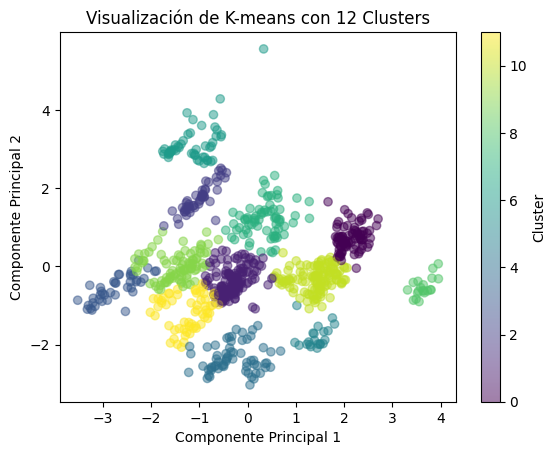

In [ ]:


# Normalizar las características numéricas
scaler = StandardScaler()
df2_scaled = scaler.fit_transform(df2[['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']])

# Rango de parámetros para explorar (número de clusters)
n_clusters_options = range(2, 50)  # Explorar de 2 a 50 clusters
best_silhouette = -1
best_n_clusters = None
best_labels = None

# Buscar el mejor número de clusters
for n_clusters in n_clusters_options:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)  # Uso explícito de n_init para evitar el warning
    labels = kmeans.fit_predict(df2_scaled)

    # Calcular el índice de Silhouette para esta configuración
    score = silhouette_score(df2_scaled, labels)

    if score > best_silhouette:
        best_silhouette = score
        best_n_clusters = n_clusters
        best_labels = labels  # Guardar las etiquetas del mejor modelo

# Imprimir los resultados del mejor modelo encontrado
print(f'Mejor número de clusters: {best_n_clusters}, Mejor Silhouette Score: {best_silhouette}')

# Aplicar PCA para visualización
pca = PCA(n_components=2)
df2_pca = pca.fit_transform(df2_scaled)

# Visualización de los clusters usando las etiquetas del mejor modelo
plt.scatter(df2_pca[:, 0], df2_pca[:, 1], c=best_labels, cmap='viridis', alpha=0.5)
plt.title(f'Visualización de K-means con {best_n_clusters} Clusters')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:

# Asegurar tipos de datos adecuados para optimizar memoria
for col in ['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']:
    df2[col] = df2[col].astype('float32')

# Seleccionar columnas para el análisis
columnas_para_escalar = ['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']

df2_analisis = df2[columnas_para_escalar]

# Normalizar las características numéricas
scaler = StandardScaler()
df2_analisis_scaled = scaler.fit_transform(df2_analisis)

# Iniciar el cronómetro para medir el tiempo de ejecución de HDBSCAN
start_time = time.time()

# Configurar y ejecutar HDBSCAN
min_cluster_size = 5  # Tamaño mínimo de un cluster
min_samples = 88      # Número mínimo de puntos para formar un cluster
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, gen_min_span_tree=True)
df2['Cluster'] = clusterer.fit_predict(df2_analisis_scaled)

# Detener el cronómetro después de ejecutar HDBSCAN
end_time = time.time()

# Calcular el tiempo total de ejecución
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución de HDBSCAN: {elapsed_time:.2f} segundos")

# Identificar las anomalías (puntos clasificados como ruido son etiquetados con -1)
anomalies = df2[df2['Cluster'] == -1]

# Mostrar las anomalías detectadas
print("Anomalías detectadas:")
print(anomalies)


Tiempo de ejecución de HDBSCAN: 0.02 segundos
Anomalías detectadas:
    Fecha_corta  Energía_Activa  Energía_Reactiva   Voltaje_FA   Voltaje_FC  \
5    2021-01-06      700.864136        511.490662  1389.282349  1385.044189   
6    2021-01-07      628.931030        473.136810  1455.301270  1454.137695   
13   2021-01-14      598.762817        470.625427  1466.673950  1460.981445   
19   2021-01-20      689.630676        470.522491  1420.842285  1435.891602   
20   2021-01-21      620.181641        454.503174  1485.497925  1500.722656   
..          ...             ...               ...          ...          ...   
816  2023-03-28      445.189575        228.411453   810.287231   897.672180   
817  2023-03-29      433.675232        247.380157   886.717712   970.068054   
818  2023-03-30      415.319794        237.542328   926.324463  1041.368408   
819  2023-03-31      405.161194        235.698547   913.326355  1027.276245   
820  2023-04-01       17.400274          5.997997   904.104858 

In [ ]:

# Normalizar las características numéricas
scaler = StandardScaler()
df2_scaled = scaler.fit_transform(df2[['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']])

# Rango de parámetros para explorar
min_cluster_sizes = range(5, 100, 2)  # Valores para min_cluster_size
min_samples_range = range(2, 100, 2)  # Valores para min_samples
best_silhouette = -1
best_params = None
best_labels = None

# Buscar la mejor configuración de HDBSCAN
for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_range:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, gen_min_span_tree=True)
        labels = clusterer.fit_predict(df2_scaled)

        # Filtrar el ruido antes de calcular Silhouette
        if len(set(labels)) > 1 and -1 in labels:
            filtered_data = df2_scaled[labels != -1]
            cluster_labels = labels[labels != -1]
            if len(set(cluster_labels)) > 1:  # Necesitamos al menos dos clusters para calcular Silhouette
                score = silhouette_score(filtered_data, cluster_labels)
                if score > best_silhouette:
                    best_silhouette = score
                    best_params = (min_cluster_size, min_samples)
                    best_labels = labels

print(f'Mejor min_cluster_size: {best_params[0]}, Mejor min_samples: {best_params[1]}, Mejor Silhouette Score: {best_silhouette}')


Mejor min_cluster_size: 5, Mejor min_samples: 88, Mejor Silhouette Score: 0.7011685371398926


<ipython-input-42-32623e9bbf30>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", len(unique_labels))


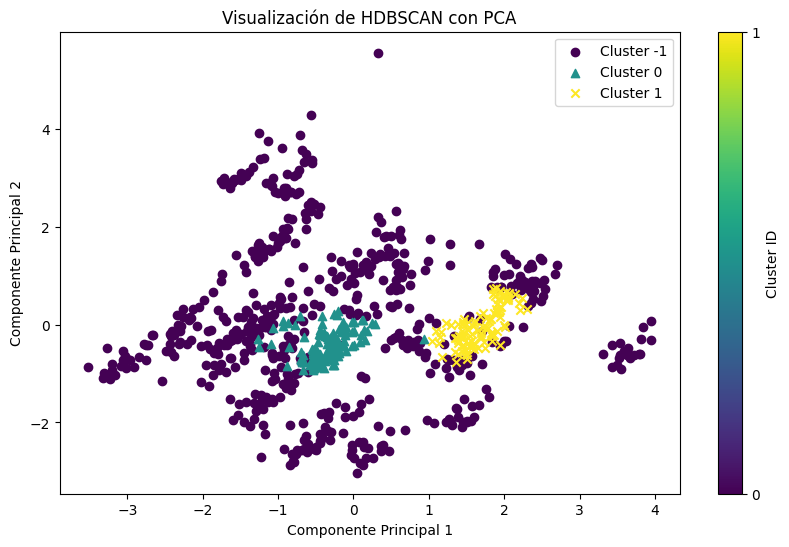

In [ ]:
# Mejor configuración encontrada para HDBSCAN
min_cluster_size = 5
min_samples = 88

clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, gen_min_span_tree=True)
labels = clusterer.fit_predict(df2_scaled)

# Aplicar PCA para la visualización
pca = PCA(n_components=2)
df2_pca = pca.fit_transform(df2_scaled)

# Visualización
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap("viridis", len(unique_labels))
markers = ['o', '^', 'x', '+', 's', 'd', 'p', '*', '<', '>']

plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    mask = labels == label
    plt.scatter(df2_pca[mask, 0], df2_pca[mask, 1], color=colors(i), label=f'Cluster {label}', marker=markers[i % len(markers)])

plt.title('Visualización de HDBSCAN con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(ticks=range(len(unique_labels)), label='Cluster ID')
plt.legend()
plt.show()


In [ ]:
# Asegurar tipos de datos adecuados para optimizar memoria
for col in ['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']:
    df2[col] = df2[col].astype('float32')

# Seleccionar columnas para el análisis
columnas_para_escalar = ['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']

df2_analisis = df2[columnas_para_escalar]

# Normalizar las características numéricas
scaler = StandardScaler()
df2_analisis_scaled = scaler.fit_transform(df2_analisis)

# Iniciar el cronómetro
start_time = time.time()

# Configurar y ejecutar DBSCAN
epsilon = 0.5  # Radio de la vecindad
min_samples = 10  # Número mínimo de puntos para formar un cluster
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
df2['Cluster'] = dbscan.fit_predict(df2_analisis_scaled)

# Detener el cronómetro
end_time = time.time()

# Calcular el tiempo total de ejecución
elapsed_time = end_time - start_time

# Mostrar el tiempo de ejecución
print(f"Tiempo de ejecución de DBSCAN: {elapsed_time:.2f} segundos")

# Identificar las anomalías (puntos clasificados como ruido son etiquetados con -1)
anomalies = df2[df2['Cluster'] == -1]

# Mostrar las anomalías detectadas
print("Anomalías detectadas:")
print(anomalies)



Tiempo de ejecución de DBSCAN: 0.01 segundos
Anomalías detectadas:
    Fecha_corta  Energía_Activa  Energía_Reactiva   Voltaje_FA   Voltaje_FC  \
83   2021-03-25      757.187866        558.769592  1666.734985  1673.824951   
372  2022-01-08     1457.751221        646.543152  1462.791504  1493.704102   
438  2022-03-15     1415.450439        634.437439  1375.362183  1353.875244   
439  2022-03-16     1447.866333        623.581909  1391.101685  1394.506226   
687  2022-11-19      372.141724        314.270996  1402.698242  1464.770752   
791  2023-03-03      458.046600        338.402283  1485.493164  1473.610718   
813  2023-03-25      285.288605        171.863205   864.778992   958.370972   
814  2023-03-26      371.274689        208.035995   889.274719   978.681335   
815  2023-03-27      431.326782        246.134857   845.261475   930.940979   
816  2023-03-28      445.189575        228.411453   810.287231   897.672180   
817  2023-03-29      433.675232        247.380157   886.717712  

In [ ]:
# Normalizar las características numéricas
scaler = StandardScaler()
df2_scaled = scaler.fit_transform(df2[['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']])

# Rango reducido de parámetros para explorar
epsilons = np.arange(0.3, 0.8, 0.2)  # Rango limitado y más grande de epsilon
min_samples = range(5, 20, 7)  # Menos valores de min_samples
best_silhouette = -1
best_params = None
best_labels = None

# Buscar la mejor configuración de DBSCAN
for eps in epsilons:
    for samples in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=samples)
        labels = dbscan.fit_predict(df2_scaled)

        # Filtrar el ruido antes de calcular Silhouette
        if len(set(labels)) > 1 and -1 in labels:
            cluster_labels = labels[labels != -1]
            filtered_data = df2_scaled[labels != -1]
            if len(set(cluster_labels)) > 1:  # Necesitamos al menos dos clusters para calcular Silhouette
                score = silhouette_score(filtered_data, cluster_labels)
                if score > best_silhouette:
                    best_silhouette = score
                    best_params = (eps, samples)
                    best_labels = labels  # Guardar todas las etiquetas incluyendo ruido para visualización

print(f'Mejor epsilon: {best_params[0]}, Mejor min_samples: {best_params[1]}, Mejor Silhouette Score: {best_silhouette}')


Mejor epsilon: 0.3, Mejor min_samples: 19, Mejor Silhouette Score: 0.6454816460609436


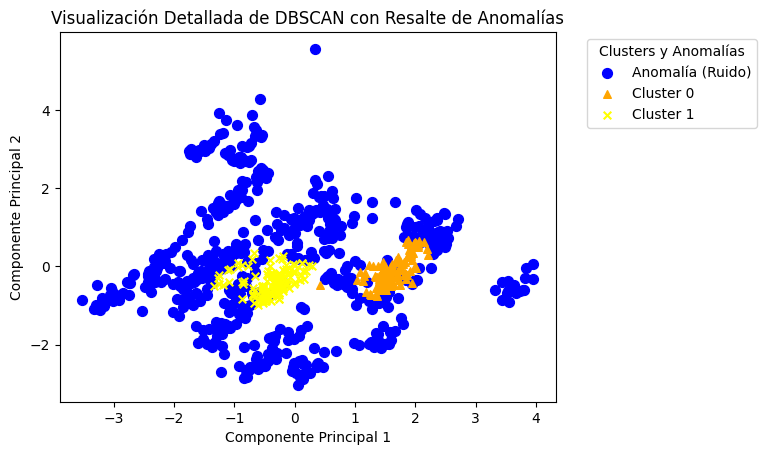

In [ ]:

# Suponiendo que df2_scaled es tu conjunto de datos ya escalado y labels es el resultado de DBSCAN
pca = PCA(n_components=2)
df2_pca = pca.fit_transform(df2_scaled)

# Colores y marcadores
colors = ['blue', 'orange', 'yellow']  # Colores para los clusters 0, 1 y ruido
cluster_ids = np.unique(labels)
markers = ['o', '^', 'x']  # Marcadores para clusters y ruido

fig, ax = plt.subplots()
for cluster_id, color, marker in zip(cluster_ids, colors, markers):
    points = df2_pca[labels == cluster_id]
    if cluster_id == -1:  # Resaltar anomalías
        ax.scatter(points[:, 0], points[:, 1], s=50, c=color, label=f'Anomalía (Ruido)', marker=marker)
    else:
        ax.scatter(points[:, 0], points[:, 1], s=30, c=color, label=f'Cluster {cluster_id}', marker=marker)

ax.set_title('Visualización Detallada de DBSCAN con Resalte de Anomalías')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.legend(title="Clusters y Anomalías", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
df

,Fecha,Energía_Activa,Energía_Reactiva,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...
...,...,...,...,...,...,...,...
462915,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,Cliente 9,Cultivo de Árboles Frutales y Nueces
462916,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,Cliente 9,Cultivo de Árboles Frutales y Nueces
462917,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,Cliente 9,Cultivo de Árboles Frutales y Nueces
462918,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,Cliente 9,Cultivo de Árboles Frutales y Nueces


In [ ]:
#Análisis de anomalías mediante una red neuronal recurrente


# Convertir 'Fecha' en índice y ordenar el DataFrame
#df.set_index('Fecha', inplace=True)
#df.sort_index(inplace=True)

# Escalar los datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']].values)

# Inicializar lista de secuencias
sequence_length = 24  # 24 pasos de tiempo para el patrón de 24 horas
sequences = []

# Crear secuencias de datos de 24 horas para cada cliente
for i in range(0, len(scaled_features) - sequence_length + 1, sequence_length):
    sequence = scaled_features[i:i + sequence_length]
    if sequence.shape[0] == sequence_length:
        sequences.append(sequence)

# Convertir a array numpy para procesamiento del modelo
sequences = np.array(sequences)

# Dividir los datos en entrenamiento y prueba
X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)

# Definir la arquitectura del autoencoder
model = Sequential([
    LSTM(128, input_shape=(sequence_length, X_train.shape[2]), return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(128, return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mae')

# Resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(X_train, X_train, epochs=50, batch_size=72, validation_data=(X_test, X_test))

# Detectar anomalías
reconstructed = model.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test - reconstructed), axis=1)
threshold = np.percentile(reconstruction_error, 95)  # Establecer umbral al percentil 95
anomalies = reconstruction_error > threshold

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 repeat_vector (RepeatVecto  (None, 24, 128)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 24, 128)           131584    
                                                                 
 time_distributed (TimeDist  (None, 24, 4)             516       
 ributed)                                                        
                                                                 
Total params: 200196 (782.02 KB)
Trainable params: 200196 (782.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
215/2

In [ ]:

# Convertir 'Fecha' en índice y ordenar el DataFrame
df.set_index('Fecha', inplace=True)
df.sort_index(inplace=True)

# Escalar los datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']].values)

# Inicializar lista de secuencias
sequence_length = 24  # 24 pasos de tiempo para el patrón de 24 horas
sequences = []

# Crear secuencias de datos de 24 horas para cada cliente
for i in range(0, len(scaled_features) - sequence_length + 1, sequence_length):
    sequence = scaled_features[i:i + sequence_length]
    if sequence.shape[0] == sequence_length:
        sequences.append(sequence)

# Convertir a array numpy para procesamiento del modelo
sequences = np.array(sequences)

# Dividir los datos en entrenamiento y prueba
X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)

# Definir la arquitectura del autoencoder
model = Sequential([
    LSTM(128, input_shape=(sequence_length, X_train.shape[2]), return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(128, return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mae')

# Resumen del modelo
model.summary()

# Iniciar el cronómetro
start_time = time.time()

# Entrenar el modelo
history = model.fit(X_train, X_train, epochs=20, batch_size=72, validation_data=(X_test, X_test))

# Detener el cronómetro
end_time = time.time()

# Calcular el tiempo total de ejecución
elapsed_time = end_time - start_time
print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

# Detectar anomalías
reconstructed = model.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test - reconstructed), axis=1)
threshold = np.percentile(reconstruction_error, 95)  # Establecer umbral al percentil 95
anomalies = reconstruction_error > threshold
print("Anomalías detectadas:", anomalies)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               68096     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 24, 128)           0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 24, 128)           131584    
                                                                 
 time_distributed_1 (TimeDi  (None, 24, 4)             516       
 stributed)                                                      
                                                                 
Total params: 200196 (782.02 KB)
Trainable params: 200196 (782.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
215

121/121 [==============================] - 0s 3ms/step


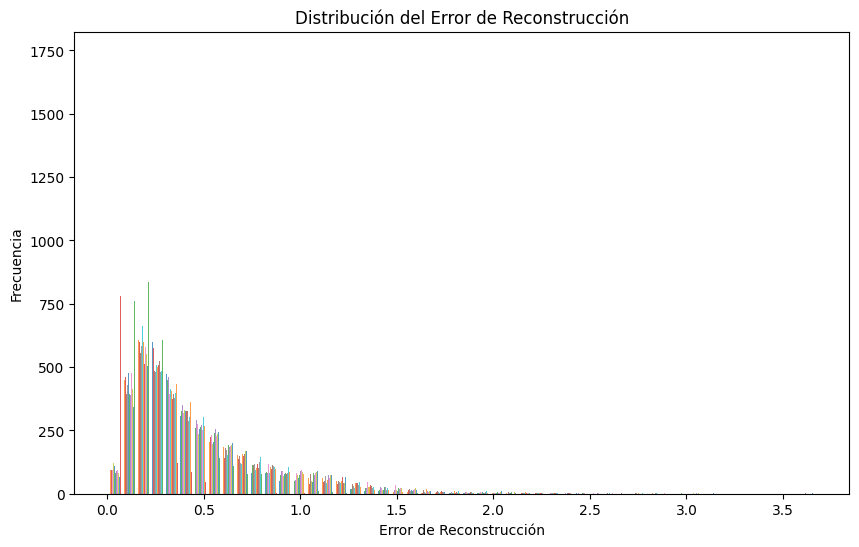

Umbral dinámico para detección de anomalías: 1.1668540563909584


In [ ]:

# Calcular el error de reconstrucción para cada muestra
reconstructed = model.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test - reconstructed), axis=-1)  # Media por cada muestra

# Visualizar la distribución del error de reconstrucción
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.title('Distribución del Error de Reconstrucción')
plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.show()

# Calcular un umbral dinámico basado en la distribución
dynamic_threshold = np.percentile(reconstruction_error, 95)
print("Umbral dinámico para detección de anomalías:", dynamic_threshold)


In [ ]:
df4 = df.copy()
df4

,Energía_Activa,Energía_Reactiva,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico
Fecha,,,,,,
2021-01-01,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...
2021-01-01,0.020158,0.069569,1924.417765,1951.933142,Cliente 16,"Captación, tratamiento y distribución de agua"
2021-01-01,1.822182,1.458711,602.017273,688.300951,Cliente 2,Elaboración de cacao y chocolate y de producto...
2021-01-01,0.915739,0.056504,1081.084983,1129.650930,Cliente 26,Venta al por mayor de metales y minerales meta...
2021-01-01,4.457443,0.980230,746.016908,709.999466,Cliente 5,Elaboración de cacao y chocolate y de producto...
...,...,...,...,...,...,...
2023-04-01,1.561563,0.537526,1557.123094,1330.161903,Cliente 8,Cultivo de Árboles Frutales y Nueces
2023-04-01,5.812355,0.983711,748.031069,599.579422,Cliente 5,Elaboración de cacao y chocolate y de producto...
2023-04-01,0.288731,0.012547,498.031069,349.579422,Cliente 4,Elaboración de cacao y chocolate y de producto...


In [ ]:
# Escalar los datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df4[['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']].values)

# Inicializar lista de secuencias
sequence_length = 24  # 24 pasos de tiempo para el patrón de 24 horas
sequences = []

# Crear secuencias de datos de 24 horas para cada cliente
for i in range(0, len(scaled_features) - sequence_length + 1, sequence_length):
    sequence = scaled_features[i:i + sequence_length]
    if sequence.shape[0] == sequence_length:
        sequences.append(sequence)

# Convertir a array numpy para procesamiento del modelo
sequences = np.array(sequences)

# Dividir los datos en entrenamiento y prueba
X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)

# Definir la arquitectura del autoencoder
model = Sequential([
    LSTM(128, input_shape=(sequence_length, X_train.shape[2]), return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(128, return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mae')

# Resumen del modelo
model.summary()

# Iniciar el cronómetro
start_time = time.time()

# Entrenar el modelo
history = model.fit(X_train, X_train, epochs=50, batch_size=72, validation_data=(X_test, X_test))

# Detener el cronómetro
end_time = time.time()

# Calcular el tiempo total de ejecución
elapsed_time = end_time - start_time
print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

# Detectar anomalías
reconstructed = model.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test - reconstructed), axis=-1)
threshold = np.percentile(reconstruction_error, 95)  # Establecer umbral al percentil 95
anomalies = reconstruction_error > threshold

# Imprimir resultados de las anomalías
print("Número de anomalías detectadas:", np.sum(anomalies))
print("Indices de las anomalías:", np.where(anomalies)[0])




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               68096     
                                                                 
 repeat_vector_2 (RepeatVec  (None, 24, 128)           0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 24, 128)           131584    
                                                                 
 time_distributed_2 (TimeDi  (None, 24, 4)             516       
 stributed)                                                      
                                                                 
Total params: 200196 (782.02 KB)
Trainable params: 200196 (782.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
215

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
# Asumiendo que df3 es tu DataFrame ya cargado
# Escalar los datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df3[['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC']].values)

# Preparar los datos como se describió anteriormente
sequences = []  # Esta parte debería estar ya definida en tu código actual
for i in range(0, len(scaled_features) - 24 + 1, 24):
    sequence = scaled_features[i:i + 24]
    if len(sequence) == 24:
        sequences.append(sequence)
sequences = np.array(sequences)

X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)

def build_model(hp):
    model = Sequential([
        LSTM(hp.Int('units', min_value=64, max_value=256, step=32), input_shape=(24, X_train.shape[2]), return_sequences=False),
        RepeatVector(24),
        LSTM(hp.Int('units', min_value=64, max_value=256, step=32), return_sequences=True),
        TimeDistributed(Dense(X_train.shape[2]))
    ])
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])), loss='mae')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
    directory='tuner_data',
    project_name='rnn_tuning'
)

tuner.search(X_train, X_train, epochs=20, validation_data=(X_test, X_test), batch_size=72, verbose=2)

# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


Trial 15 Complete [00h 00m 33s]
val_loss: 0.6467509269714355

Best val_loss So Far: 0.3332224190235138
Total elapsed time: 00h 08m 17s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               267264    
                                                                 
 repeat_vector (RepeatVecto  (None, 24, 256)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 24, 256)           525312    
                                                                 
 time_distributed (TimeDist  (None, 24, 4)             1028      
 ributed)                                                        
                                                                 
Total params: 793604 (3.03 MB)
Trainable params: 7936

In [ ]:
tf.get_logger().setLevel('ERROR')  # Establece el nivel de logging a ERROR para silenciar los warnings


# Obtener la mejor configuración de hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Mostrar la configuración de hiperparámetros del mejor modelo
print("La mejor configuración de hiperparámetros encontrada:")
print(f"Unidades LSTM: {best_hps.get('units')}")
print(f"Tasa de aprendizaje del optimizador Adam: {best_hps.get('learning_rate')}")

# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]

# Mostrar un resumen del mejor modelo
print("Resumen del mejor modelo:")
best_model.summary()

# Obtener la mejor puntuación obtenida
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"La mejor pérdida de validación obtenida fue: {best_trial.score}")


La mejor configuración de hiperparámetros encontrada:
Unidades LSTM: 256
Tasa de aprendizaje del optimizador Adam: 0.001
Resumen del mejor modelo:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               267264    
                                                                 
 repeat_vector (RepeatVecto  (None, 24, 256)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 24, 256)           525312    
                                                                 
 time_distributed (TimeDist  (None, 24, 4)             1028      
 ributed)                                                        
                                                                 
Total params: 793604 (3.03 MB)
Trainable 

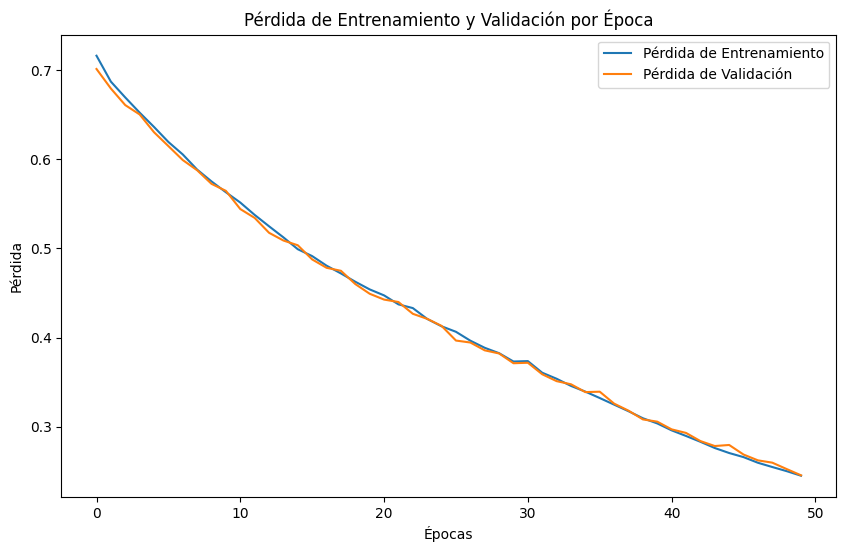

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación por Época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


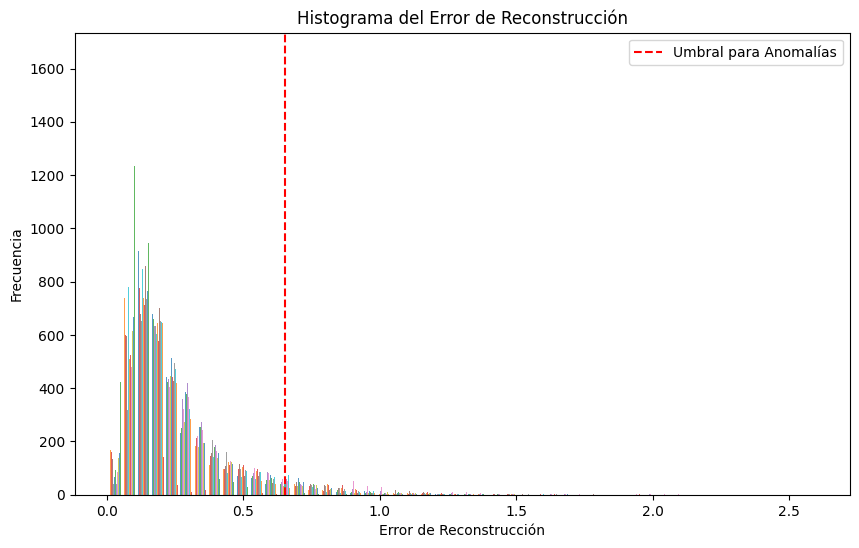

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.axvline(x=threshold, color='r', linestyle='--', label='Umbral para Anomalías')
plt.title('Histograma del Error de Reconstrucción')
plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


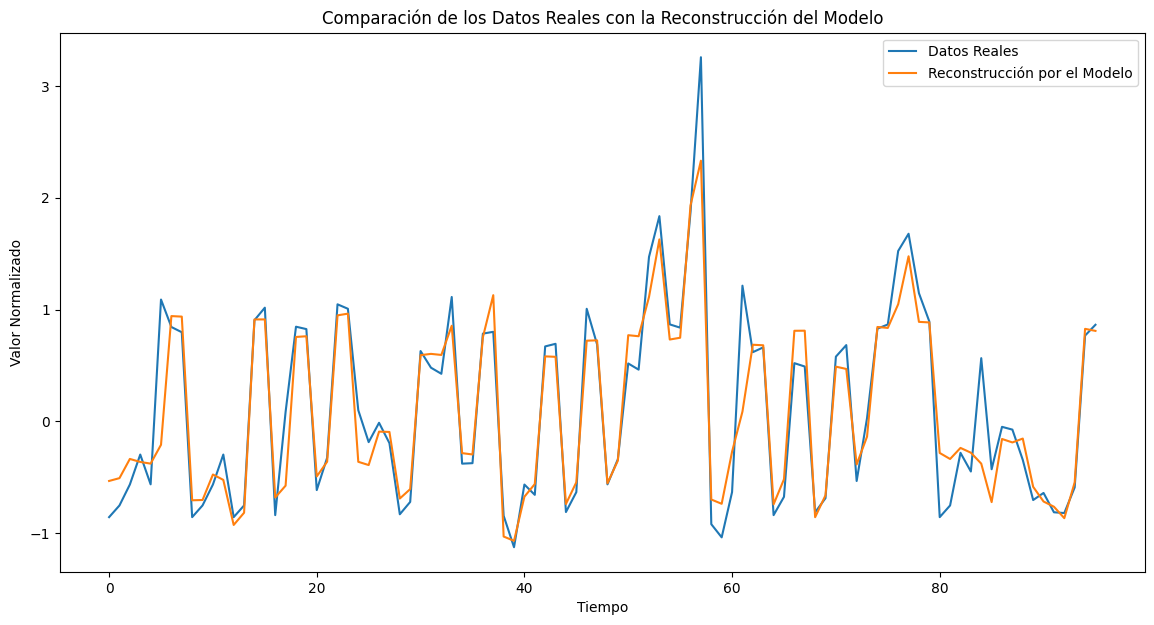

In [ ]:
# Selecciona una secuencia de los datos de prueba
real_data = X_test[0]
predicted_data = reconstructed[0]

plt.figure(figsize=(14, 7))
plt.plot(real_data.flatten(), label='Datos Reales')
plt.plot(predicted_data.flatten(), label='Reconstrucción por el Modelo')
plt.title('Comparación de los Datos Reales con la Reconstrucción del Modelo')
plt.xlabel('Tiempo')
plt.ylabel('Valor Normalizado')
plt.legend()
plt.show()


In [ ]:

# Restaurar los índices del DataFrame original
df_indexed = df.reset_index()

# Preparar una lista para marcar cada punto de datos como normal o anómalo
anomaly_labels = []
for idx, anomaly in zip(range(len(X_test)), anomalies):
    anomaly_labels.extend([anomaly] * sequence_length)  # Repetir la etiqueta de anomalía para cada punto en la secuencia

# Asegurar que la cantidad de etiquetas coincida con la cantidad de filas en el DataFrame
if len(anomaly_labels) > len(df_indexed):
    anomaly_labels = anomaly_labels[:len(df_indexed)]  # Ajustar en caso de que haya más etiquetas que filas
elif len(anomaly_labels) < len(df_indexed):
    # Añadir False para las filas restantes si es necesario
    anomaly_labels.extend([False] * (len(df_indexed) - len(anomaly_labels)))

# Añadir las etiquetas de anomalías al DataFrame
df_indexed['anomalies_RNN'] = anomaly_labels

# Contar el total de anomalías detectadas
total_anomalies = df_indexed['anomalies_RNN'].sum()

# Mostrar el total de anomalías
print("Total de anomalías detectadas:", total_anomalies)

# Mostrar las primeras filas del DataFrame modificado
df_indexed


Total de anomalías detectadas: [ True  True  True  True  True  True  True  True  True]


,Fecha,Energía_Activa,Energía_Reactiva,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico,eficiencia_energetica,energia_total_consumida,Energía_Aparente,Factor_de_Potencia,Desviación_Voltaje,Cluster,Es_Anomalia,anomalies_RNN
0,2021-01-01,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...,55.857724,0.640629,0.208019,1.720229,55.421831,0,0,"[False, False, False, False, False, False, Fal..."
1,2021-01-01,0.020158,0.069569,1924.417765,1951.933142,Cliente 16,"Captación, tratamiento y distribución de agua",22.465635,0.089727,0.005246,3.842333,27.515377,0,0,"[False, False, False, False, False, False, Fal..."
2,2021-01-01,1.822182,1.458711,602.017273,688.300951,Cliente 2,Elaboración de cacao y chocolate y de producto...,55.539218,3.280893,5.448186,0.334457,86.283678,0,0,"[False, False, False, False, False, False, Fal..."
3,2021-01-01,0.915739,0.056504,1081.084983,1129.650930,Cliente 26,Venta al por mayor de metales y minerales meta...,94.188240,0.972244,0.841771,1.087872,48.565946,0,0,"[False, False, False, False, False, False, Fal..."
4,2021-01-01,4.457443,0.980230,746.016908,709.999466,Cliente 5,Elaboración de cacao y chocolate y de producto...,81.973350,5.437674,20.829653,0.213995,36.017442,0,0,"[False, False, False, False, False, False, Fal..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462915,2023-04-01,1.561563,0.537526,1557.123094,1330.161903,Cliente 8,Cultivo de Árboles Frutales y Nueces,74.392420,2.099089,2.727412,0.572544,226.961191,0,0,False
462916,2023-04-01,5.812355,0.983711,748.031069,599.579422,Cliente 5,Elaboración de cacao y chocolate y de producto...,85.525287,6.796066,34.751155,0.167256,148.451646,0,0,False
462917,2023-04-01,0.288731,0.012547,498.031069,349.579422,Cliente 4,Elaboración de cacao y chocolate y de producto...,95.835371,0.301278,0.083523,3.456903,148.451646,0,0,False
462918,2023-04-01,2.091201,0.222569,1449.098586,1560.341776,Cliente 7,Cultivo de Árboles Frutales y Nueces,90.380697,2.313770,4.422659,0.472838,111.243189,0,0,False


In [ ]:
df_indexed['anomalies_RNN'] = df_indexed['anomalies_RNN'].astype(int)


In [ ]:
#Análisis rangos intercuartílicos

# Iniciar el tiempo de ejecución
start_time = time.time()

# Crear una copia del dataframe con las columnas seleccionadas
df_iqr = df[['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC', 'Cliente',
             'eficiencia_energetica', 'energia_total_consumida', 'Energía_Aparente',
             'Factor_de_Potencia', 'Desviación_Voltaje']].copy()

# Lista de columnas numéricas para analizar
columnas_numericas = ['Energía_Activa', 'Energía_Reactiva', 'Voltaje_FA', 'Voltaje_FC',
                      'eficiencia_energetica', 'energia_total_consumida', 'Energía_Aparente',
                      'Factor_de_Potencia', 'Desviación_Voltaje']

# Calcular IQR y detectar anomalías
for col in columnas_numericas:
    Q1 = df_iqr[col].quantile(0.25)
    Q3 = df_iqr[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Crear una nueva columna para marcar las anomalías
    df_iqr[col + '_anomalía'] = ((df_iqr[col] < lower_bound) | (df_iqr[col] > upper_bound)).astype(int)

# Sumar todas las anomalías por registro en una nueva columna
df_iqr['Total_anomalías_IQR'] = df_iqr[[col + '_anomalía' for col in columnas_numericas]].sum(axis=1)

# Finalizar el tiempo de ejecución y calcular la duración
end_time = time.time()
duration = end_time - start_time

print(f"Tiempo de ejecución del script: {duration} segundos")


Tiempo de ejecución del script: 0.5014317035675049 segundos


In [ ]:
df_iqr

,Energía_Activa,Energía_Reactiva,Voltaje_FA,Voltaje_FC,Cliente,eficiencia_energetica,energia_total_consumida,Energía_Aparente,Factor_de_Potencia,Desviación_Voltaje,Energía_Activa_anomalía,Energía_Reactiva_anomalía,Voltaje_FA_anomalía,Voltaje_FC_anomalía,eficiencia_energetica_anomalía,energia_total_consumida_anomalía,Energía_Aparente_anomalía,Factor_de_Potencia_anomalía,Desviación_Voltaje_anomalía,Total_anomalías_IQR
0,0.357841,0.282788,455.139160,510.561005,Cliente 1,55.857723,0.640629,0.208019,1.720229,55.421831,0,0,0,0,0,0,0,0,0,0
1,0.372264,0.431377,469.978790,469.917175,Cliente 1,46.322174,0.803642,0.324667,1.146603,0.061610,0,0,0,0,0,0,0,0,0,0
2,1.044687,0.338626,468.721130,546.949158,Cliente 1,75.520676,1.383312,1.206038,0.866214,78.228027,0,0,0,0,0,0,0,0,0,0
3,0.566425,0.495791,452.329254,444.122986,Cliente 1,53.324795,1.062216,0.566646,0.999609,8.206266,0,0,0,0,0,0,0,0,0,0
4,1.080556,0.472018,513.477600,535.463745,Cliente 1,69.597702,1.552575,1.390403,0.777153,21.986123,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462915,0.231000,0.309493,1343.358521,1288.567383,Cliente 9,42.738747,0.540493,0.149147,1.548807,54.791156,0,0,0,0,0,0,0,0,0,0
462916,0.041937,0.314091,1050.653564,1266.553955,Cliente 9,11.779110,0.356027,0.100412,0.417650,215.900367,0,0,0,0,0,0,0,0,0,0
462917,0.231000,0.266937,1104.985840,991.259399,Cliente 9,46.391365,0.497938,0.124617,1.853685,113.726457,0,0,0,0,0,0,0,0,0,0
462918,0.150296,0.312547,1284.048584,1091.283691,Cliente 9,32.472313,0.462843,0.120275,1.249606,192.764929,0,0,0,0,0,0,0,0,0,0


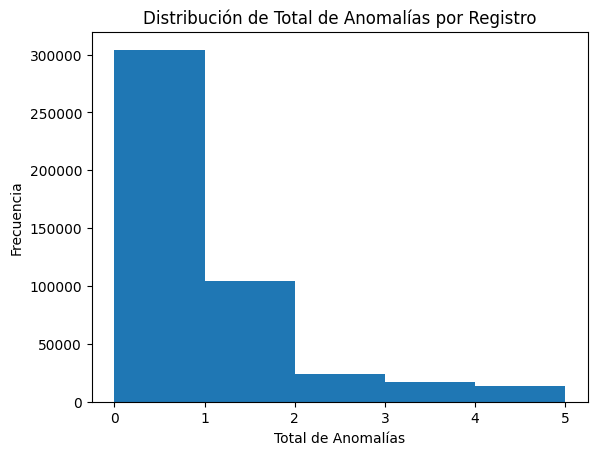

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df_iqr['Total_anomalías_IQR'], bins=range(int(df_iqr['Total_anomalías_IQR'].max()) + 1))
plt.title('Distribución de Total de Anomalías por Registro')
plt.xlabel('Total de Anomalías')
plt.ylabel('Frecuencia')
plt.show()


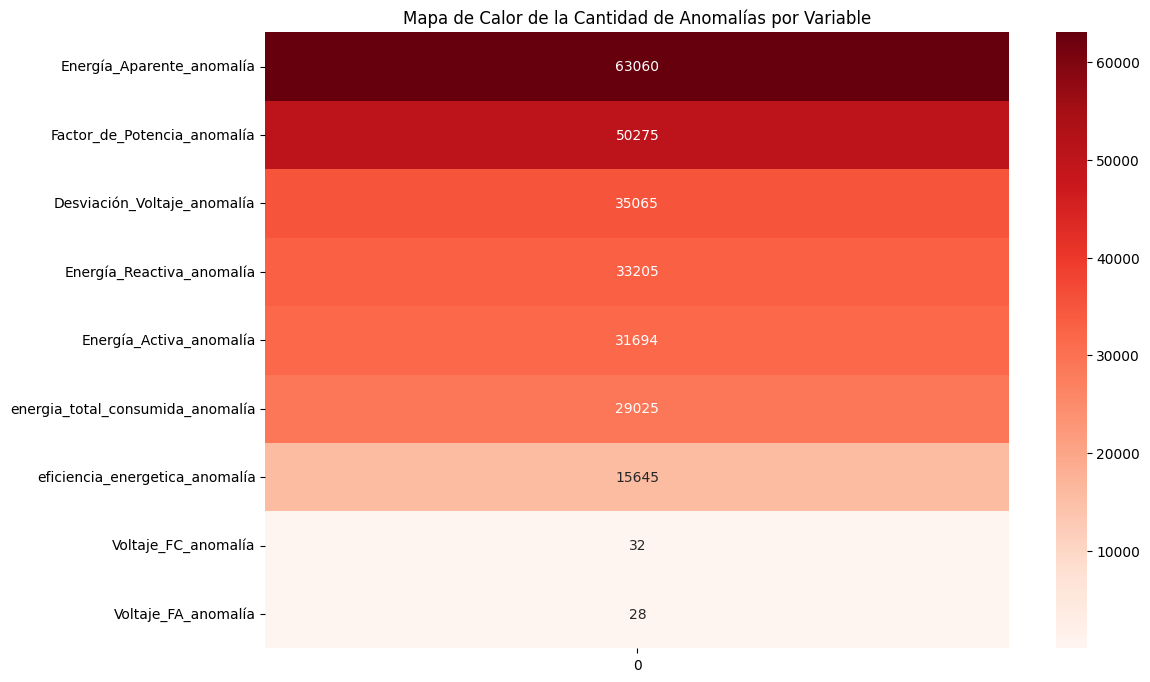

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un dataframe para el mapa de calor
heatmap_data = df_iqr[[col + '_anomalía' for col in columnas_numericas]]
heatmap_data = heatmap_data.apply(np.sum, axis=0).sort_values(ascending=False)

# Dibujar el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(data=heatmap_data.values.reshape(-1, 1), yticklabels=heatmap_data.index, annot=True, fmt="d", cmap='Reds')
plt.title('Mapa de Calor de la Cantidad de Anomalías por Variable')
plt.show()


Fuentes:
https://www.atcp-ndt.com/es/soporte/faq_trz/455-que-son-los-parametros-fa-za-fr-zr-y-fc.html


#### Descomposición series temporales

In [ ]:
#Agrupar por fecha y sector económico, y sumar el consumo eléctrico y la desviación de voltaje
consumo_agregado1 = df.groupby(['Fecha']).agg({'energia_total_consumida': 'sum', 'Desviación_Voltaje': 'sum','Energía_Activa': 'sum', 'Energía_Reactiva': 'sum'}).reset_index()

# Agregar la mediana de la eficiencia energética
eficiencia_mediana = df.groupby(['Fecha'])['eficiencia_energetica'].median().reset_index()
consumo_agregado1 = pd.merge(consumo_agregado1, eficiencia_mediana, on=['Fecha'])

consumo_agregado1.set_index('Fecha', inplace=True)

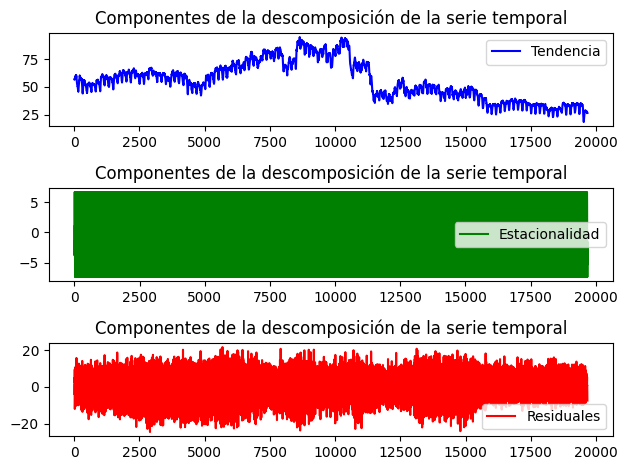

In [ ]:
# Componente de tendencia
descomposicion = sm.tsa.seasonal_decompose(consumo_agregado1['energia_total_consumida'], model='additive')
trend, seasonal, residuals = descomposicion.trend, descomposicion.seasonal, descomposicion.resid

# Convierte los componentes en arrays NumPy
trend_array = trend.to_numpy()
seasonal_array = seasonal.to_numpy()
residuals_array = residuals.to_numpy()


plt.subplot(311)
plt.plot(trend_array, label='Tendencia', color='blue')
plt.title('Componentes de la descomposición de la serie temporal')
plt.legend()

# Componente estacional
plt.subplot(312)
plt.plot(seasonal_array, label='Estacionalidad', color='green')
plt.title('Componentes de la descomposición de la serie temporal')
plt.legend()

# Componente residual
plt.subplot(313)
plt.plot(residuals_array, label='Residuales', color='red')
plt.title('Componentes de la descomposición de la serie temporal')
plt.legend()

plt.tight_layout()
plt.show()

#### Proyecciones Series Temporales

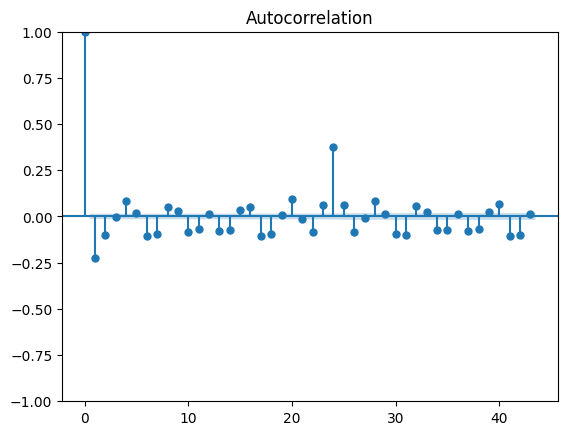

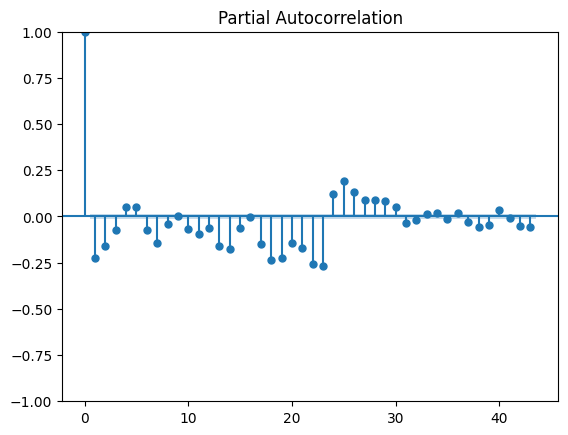

In [ ]:
data3 = consumo_agregado1['energia_total_consumida']

data_diff = data3.diff().dropna()

plot_acf(data_diff)
plot_pacf(data_diff)
plt.show()

In [ ]:


model = pmdarima.auto_arima(data3)

print(model.summary())

# Extract the order of the model
p = model.order[0]
d = model.order[1]
q = model.order[2]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                19681
Model:               SARIMAX(1, 1, 3)   Log Likelihood              -64243.217
Date:                Mon, 06 May 2024   AIC                         128496.434
Time:                        23:42:09   BIC                         128535.871
Sample:                    01-01-2021   HQIC                        128509.347
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7958      0.008    102.748      0.000       0.781       0.811
ma.L1         -1.1434      0.010   -112.553      0.000      -1.163      -1.124
ma.L2          0.1324      0.010     12.799      0.0

El modelo AutoARIMA ajustó un modelo SARIMAX(1, 1, 3) a los datos de la serie temporal. Este modelo muestra un buen ajuste a los datos, con coeficientes significativos para los términos autoregresivos y de medias móviles. La varianza de los errores es de 40.0777, y las pruebas de autocorrelación residual y heterocedasticidad indican que el modelo es adecuado. Sin embargo, los residuos no siguen estrictamente una distribución normal, lo que puede indicar alguna no linealidad en los datos no capturada por el modelo.

In [ ]:
# Selección del orden del modelo
model = ARIMA(data3, order=(p, d, q))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Error cuadrático medio (MSE): 40.200363794503225
Error absoluto medio (MAE): 4.841475763113811
Criterio de Akaike para la información corregida (AICc): 128496.4372703165
Criterio de Schwarz para la información corregida (BIC): 128535.87101145925


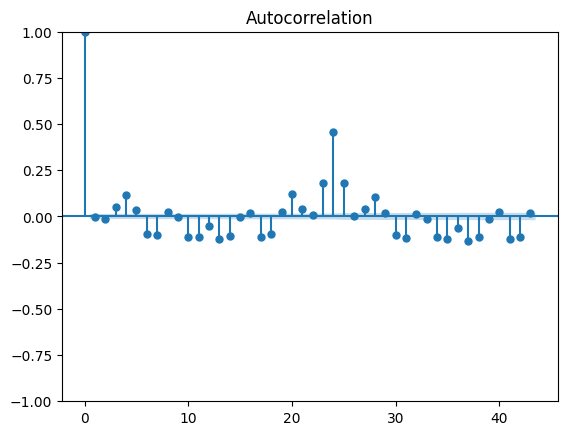

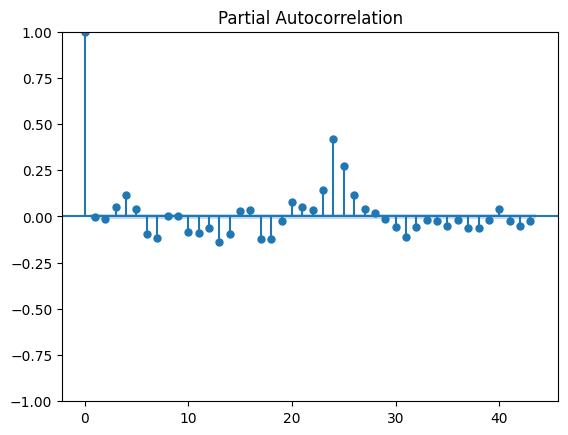

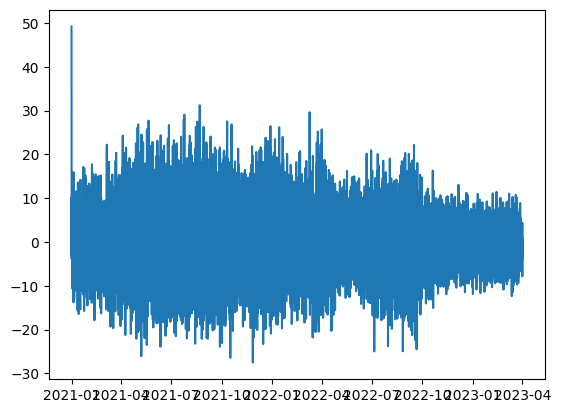

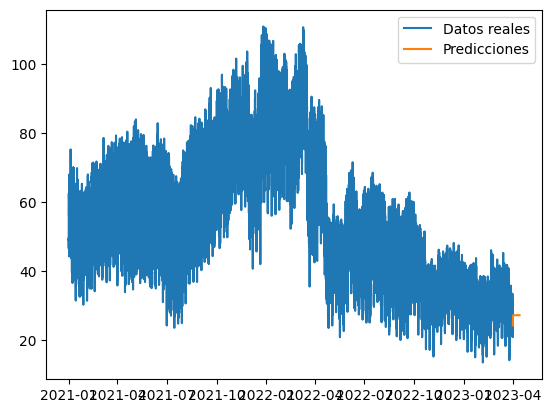

In [ ]:

# Medidas estadísticas
print("Error cuadrático medio (MSE):", model_fit.mse)
# Comment out the next line to fix the error
# print("Raíz cuadrada del error cuadrático medio (RMSE):", model_fit.rmse)
print("Error absoluto medio (MAE):", model_fit.mae)

print("Criterio de Akaike para la información corregida (AICc):", model_fit.aicc)
print("Criterio de Schwarz para la información corregida (BIC):", model_fit.bic)

# Análisis gráfico
plot_acf(model_fit.resid)
plt.show()

plot_pacf(model_fit.resid)
plt.show()

# Gráfico de residuos
plt.plot(model_fit.resid)
plt.show()

# Predicción
predicciones = model_fit.forecast(steps=300)
plt.plot(data3, label="Datos reales")
plt.plot(predicciones.index, predicciones.values, label="Predicciones")
plt.legend()
plt.show()

# Verificación de Supuestos

In [ ]:
# Seleccionar las columnas requeridas y establecer la columna "Fecha" como índice
df_v = df[['Fecha', 'Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]

df_v['Fecha'] = pd.to_datetime(df_v['Fecha'])  # Convertir la columna Fecha a tipo datetime

# Crear una nueva columna de Fecha corta (sin hora)
df_v['Fecha_Corta'] = df_v['Fecha'].dt.date

df_v['Fecha_Corta'] = pd.to_datetime(df_v['Fecha_Corta'])

# Agrupar por día y aplicar las medidas solicitadas
df_g = df_v.groupby(df_v['Fecha_Corta'].dt.date).agg({
    'Active_energy': 'sum',           # Suma de Energía Activa
    'Reactive_energy': 'sum',         # Suma de Energía Reactiva
    'Voltaje_FA': 'median',           # Mediana de Voltaje FA
    'Voltaje_FC': 'median'            # Mediana de Voltaje FC
})

<ipython-input-15-5d0b795ba160>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v['Fecha'] = pd.to_datetime(df_v['Fecha'])  # Convertir la columna Fecha a tipo datetime
<ipython-input-15-5d0b795ba160>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v['Fecha_Corta'] = df_v['Fecha'].dt.date
<ipython-input-15-5d0b795ba160>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df_g

,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC
Fecha_Corta,,,,
2021-01-01,792.554394,567.520550,1537.713774,1563.925227
2021-01-02,830.433269,574.908080,1479.128204,1507.705910
2021-01-03,831.038542,600.783535,1455.847383,1398.834858
2021-01-04,827.143279,588.552008,1562.564301,1570.641230
2021-01-05,754.070047,528.601552,1588.836425,1540.329245
...,...,...,...,...
2023-03-28,445.189565,228.411447,690.485102,834.467076
2023-03-29,433.675223,247.380164,682.011487,849.699439
2023-03-30,415.319802,237.542330,747.061706,928.083995


### Variables Relacionadas Linealmente

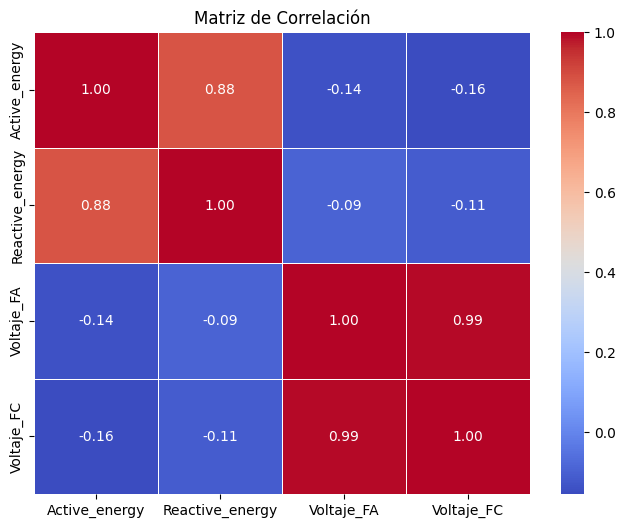

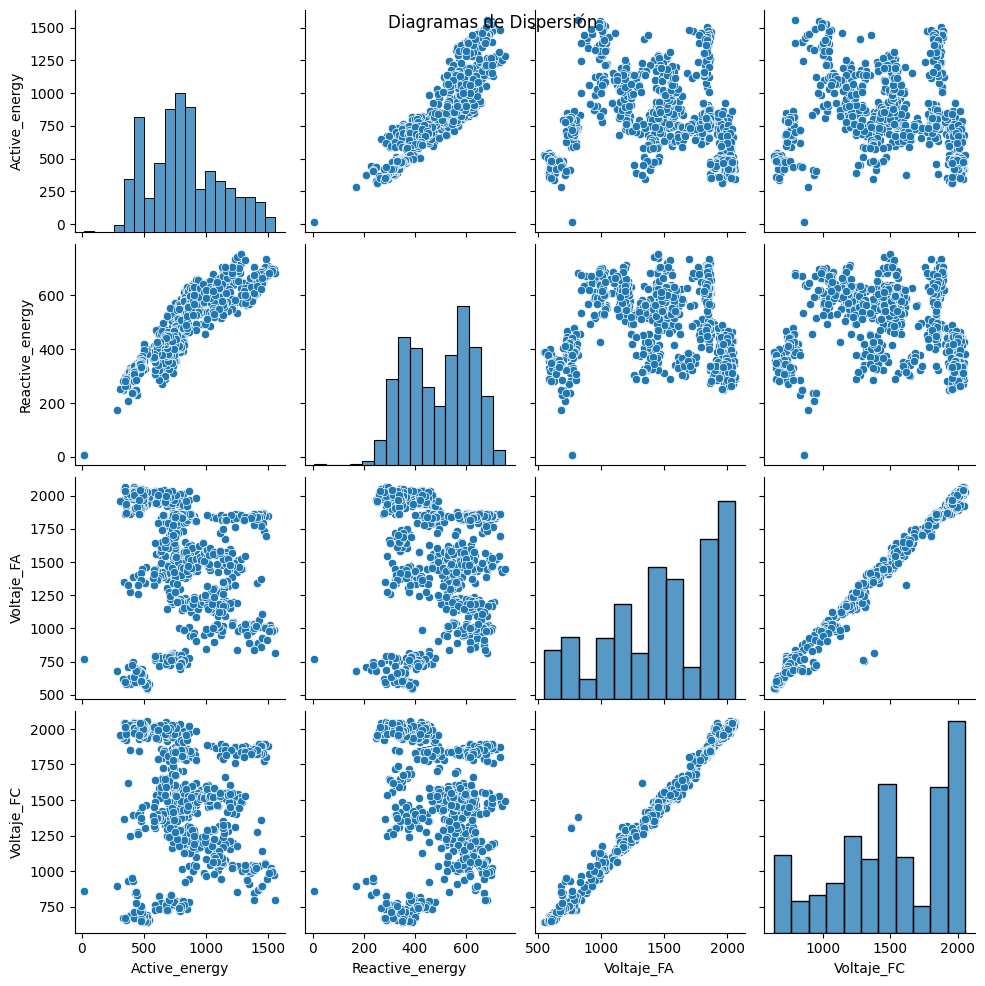

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = df_g.corr()

# Graficar la matriz de correlación como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

# Graficar diagramas de dispersión para visualizar la relación lineal
sns.pairplot(df_g[['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']])
plt.suptitle('Diagramas de Dispersión')
plt.show()


### Distribución Normal

In [ ]:
from scipy.stats import shapiro

# Realizar la prueba de Shapiro-Wilk para cada variable en el DataFrame df_v
for column in ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']:
    stat, p = shapiro(df_g[column])
    alpha = 0.05
    if p > alpha:
        print(f'La variable {column} parece seguir una distribución normal (p-value: {p:.4f})')
    else:
        print(f'La variable {column} no parece seguir una distribución normal (p-value: {p:.4f})')

La variable Active_energy no parece seguir una distribución normal (p-value: 0.0000)
La variable Reactive_energy no parece seguir una distribución normal (p-value: 0.0000)
La variable Voltaje_FA no parece seguir una distribución normal (p-value: 0.0000)
La variable Voltaje_FC no parece seguir una distribución normal (p-value: 0.0000)


### Estacionariedad

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Definir una función para realizar la prueba ADF y mostrar los resultados
def test_stationarity(timeseries):
    # Realizar la prueba de Dickey-Fuller
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Estadística de la Prueba', 'Valor-p', '# de Retrasos Utilizados', '# de Observaciones Utilizadas'])
    for key, value in dftest[4].items():
        dfoutput['Valor Crítico (%s)'%key] = value
    print(dfoutput)

    # Determinar si la serie es estacionaria o no
    if dfoutput['Valor-p'] <= 0.05:
        print("La serie es estacionaria (p <= 0.05)")
    else:
        print("La serie no es estacionaria (p > 0.05)")

# Aplicar la función de prueba a las series de datos
test_stationarity(df_g['Active_energy'])
test_stationarity(df_g['Reactive_energy'])
test_stationarity(df_g['Voltaje_FA'])
test_stationarity(df_g['Voltaje_FC'])



Resultados de la Prueba de Dickey-Fuller:
Estadística de la Prueba          -0.483578
Valor-p                            0.895181
# de Retrasos Utilizados          21.000000
# de Observaciones Utilizadas    799.000000
Valor Crítico (1%)                -3.438561
Valor Crítico (5%)                -2.865164
Valor Crítico (10%)               -2.568700
dtype: float64
La serie no es estacionaria (p > 0.05)
Resultados de la Prueba de Dickey-Fuller:
Estadística de la Prueba          -0.543223
Valor-p                            0.883302
# de Retrasos Utilizados          21.000000
# de Observaciones Utilizadas    799.000000
Valor Crítico (1%)                -3.438561
Valor Crítico (5%)                -2.865164
Valor Crítico (10%)               -2.568700
dtype: float64
La serie no es estacionaria (p > 0.05)
Resultados de la Prueba de Dickey-Fuller:
Estadística de la Prueba          -3.927441
Valor-p                            0.001842
# de Retrasos Utilizados          21.000000
# de Observaciones

### No autocorrelación de los residuos

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


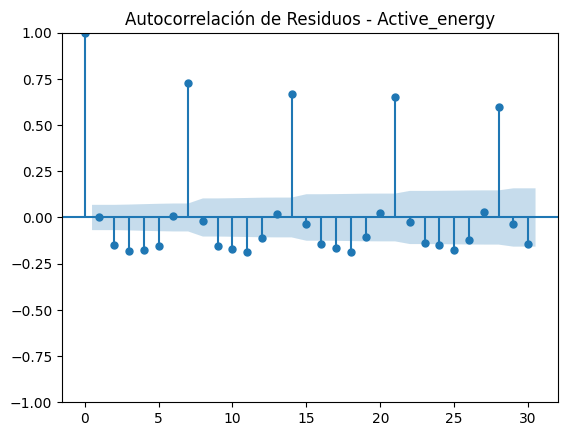

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


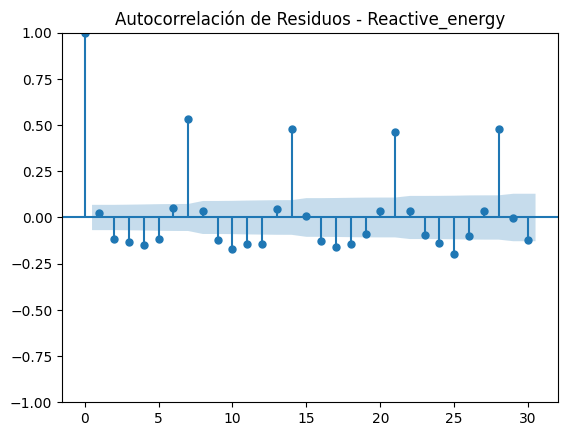

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


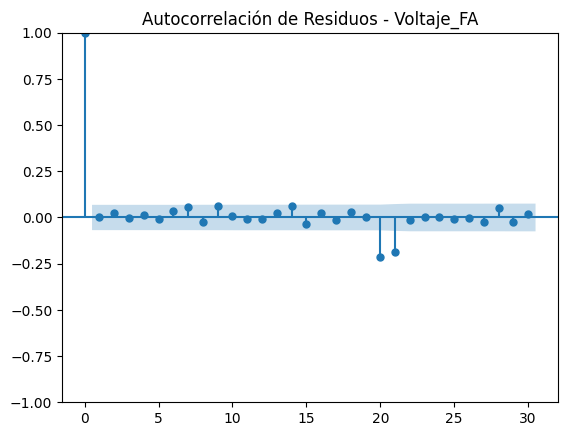

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


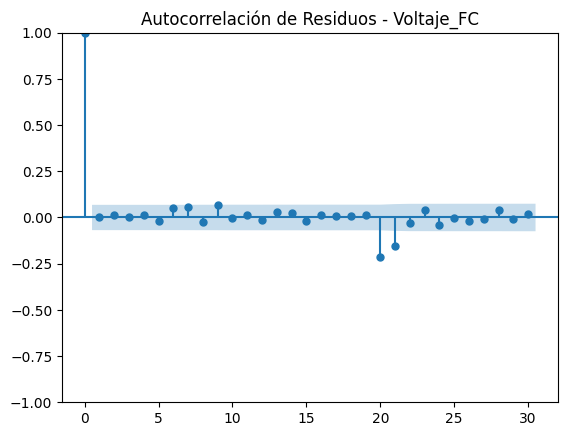

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

# Ajustar un modelo ARIMA a cada serie y evaluar la autocorrelación de los residuos
for column in ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']:
    # Ajustar un modelo ARIMA a la serie actual
    model = ARIMA(df_g[column], order=(1,0,1))  # Por ejemplo, un modelo ARIMA(1,0,1)
    model_fit = model.fit()

    # Obtener los residuos del modelo ajustado
    residuals = model_fit.resid

    # Graficar la función de autocorrelación de los residuos
    plot_acf(residuals, title=f'Autocorrelación de Residuos - {column}')
    plt.show()



### Normalidad de los residuos

In [ ]:

from scipy.stats import shapiro, kstest
from statsmodels.tsa.arima.model import ARIMA

# Función para aplicar las pruebas de Shapiro-Wilk y Kolmogorov-Smirnov
def test_normality(residuals):
    # Prueba de Shapiro-Wilk
    stat_sw, p_sw = shapiro(residuals)
    print(f'Prueba de Shapiro-Wilk - Estadística: {stat_sw}, Valor-p: {p_sw}')
    if p_sw > 0.05:
        print('Los residuos parecen seguir una distribución normal según la prueba de Shapiro-Wilk')
    else:
        print('Los residuos no parecen seguir una distribución normal según la prueba de Shapiro-Wilk')

    # Prueba de Kolmogorov-Smirnov
    stat_ks, p_ks = kstest(residuals, 'norm')
    print(f'Prueba de Kolmogorov-Smirnov - Estadística: {stat_ks}, Valor-p: {p_ks}')
    if p_ks > 0.05:
        print('Los residuos parecen seguir una distribución normal según la prueba de Kolmogorov-Smirnov')
    else:
        print('Los residuos no parecen seguir una distribución normal según la prueba de Kolmogorov-Smirnov')
    print('\n')

# Ajustar un modelo ARIMA a cada serie y aplicar las pruebas de normalidad a los residuos
for column in ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']:
    # Ajustar un modelo ARIMA a la serie actual
    model = ARIMA(df_g[column], order=(1,0,1))  # Por ejemplo, un modelo ARIMA(1,0,1)
    model_fit = model.fit()

    # Obtener los residuos del modelo ajustado
    residuals = model_fit.resid

    print(f'Pruebas de normalidad para los residuos de la serie {column}:')
    test_normality(residuals)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pruebas de normalidad para los residuos de la serie Active_energy:
Prueba de Shapiro-Wilk - Estadística: 0.9798995852470398, Valor-p: 3.3641591734578924e-09
Los residuos no parecen seguir una distribución normal según la prueba de Shapiro-Wilk
Prueba de Kolmogorov-Smirnov - Estadística: 0.5032631788978302, Valor-p: 5.522412708451395e-193
Los residuos no parecen seguir una distribución normal según la prueba de Kolmogorov-Smirnov




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pruebas de normalidad para los residuos de la serie Reactive_energy:
Prueba de Shapiro-Wilk - Estadística: 0.9757927656173706, Valor-p: 1.9976412191091697e-10
Los residuos no parecen seguir una distribución normal según la prueba de Shapiro-Wilk
Prueba de Kolmogorov-Smirnov - Estadística: 0.46431692881534936, Valor-p: 1.251087791378863e-162
Los residuos no parecen seguir una distribución normal según la prueba de Kolmogorov-Smirnov




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pruebas de normalidad para los residuos de la serie Voltaje_FA:
Prueba de Shapiro-Wilk - Estadística: 0.6211085319519043, Valor-p: 5.336232833952156e-39
Los residuos no parecen seguir una distribución normal según la prueba de Shapiro-Wilk
Prueba de Kolmogorov-Smirnov - Estadística: 0.48720895731954655, Valor-p: 4.328822244476819e-180
Los residuos no parecen seguir una distribución normal según la prueba de Kolmogorov-Smirnov




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pruebas de normalidad para los residuos de la serie Voltaje_FC:
Prueba de Shapiro-Wilk - Estadística: 0.6105303764343262, Valor-p: 2.1971000661102737e-39
Los residuos no parecen seguir una distribución normal según la prueba de Shapiro-Wilk
Prueba de Kolmogorov-Smirnov - Estadística: 0.480365479900564, Valor-p: 9.302536743889727e-175
Los residuos no parecen seguir una distribución normal según la prueba de Kolmogorov-Smirnov




### Varianza constante de los residuos (Homoscedasticidad)

In [ ]:
!pip install ARCH

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2  # Importa la distribución chi-cuadrado
from statsmodels.tsa.arima.model import ARIMA

# Función para calcular la Prueba de McLeod-Li e interpretar el valor p
def mcleod_li_test(residuals):
    n = len(residuals)
    omega = np.mean(residuals**2)
    delta_sq = np.sum((residuals[1:] - residuals[:-1])**2) / (n - 1)
    lm = (n / 2) * np.log(omega / delta_sq)
    p_value = 1 - chi2.cdf(lm, 1)  # Calcula el valor p utilizando la distribución chi-cuadrado
    if p_value < 0.05:
        interpretation = "Rechazamos la hipótesis nula: hay evidencia de heterocedasticidad en los residuos."
    else:
        interpretation = "No rechazamos la hipótesis nula: no hay suficiente evidencia de heterocedasticidad en los residuos."
    return lm, p_value, interpretation

# Suponiendo que df_g es tu DataFrame agrupado con las medidas solicitadas

# Ajustar un modelo ARIMA a cada serie y evaluar la Prueba de McLeod-Li en los residuos
for column in ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']:
    # Ajustar un modelo ARIMA a la serie actual
    model = ARIMA(df_g[column], order=(1,0,1), freq='D')  # Especifica la frecuencia como 'D' para diaria
    model_fit = model.fit()

    # Obtener los residuos del modelo ajustado
    residuals = model_fit.resid

    # Calcular la Prueba de McLeod-Li en los residuos e interpretar el valor p
    lm, p_value, interpretation = mcleod_li_test(residuals)
    print(f'Prueba de McLeod-Li para los residuos de la serie {column}: Estadística LM = {lm}, p-valor = {p_value}')
    print(f'Interpretación: {interpretation}\n')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
<ipython-input-34-7b166204a312>:11: RuntimeWarning: divide by zero encountered in scalar divide
  lm = (n / 2) * np.log(omega / delta_sq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Prueba de McLeod-Li para los residuos de la serie Active_energy: Estadística LM = inf, p-valor = 0.0
Interpretación: Rechazamos la hipótesis nula: hay evidencia de heterocedasticidad en los residuos.



<ipython-input-34-7b166204a312>:11: RuntimeWarning: divide by zero encountered in scalar divide
  lm = (n / 2) * np.log(omega / delta_sq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Prueba de McLeod-Li para los residuos de la serie Reactive_energy: Estadística LM = inf, p-valor = 0.0
Interpretación: Rechazamos la hipótesis nula: hay evidencia de heterocedasticidad en los residuos.



<ipython-input-34-7b166204a312>:11: RuntimeWarning: divide by zero encountered in scalar divide
  lm = (n / 2) * np.log(omega / delta_sq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Prueba de McLeod-Li para los residuos de la serie Voltaje_FA: Estadística LM = inf, p-valor = 0.0
Interpretación: Rechazamos la hipótesis nula: hay evidencia de heterocedasticidad en los residuos.

Prueba de McLeod-Li para los residuos de la serie Voltaje_FC: Estadística LM = inf, p-valor = 0.0
Interpretación: Rechazamos la hipótesis nula: hay evidencia de heterocedasticidad en los residuos.



<ipython-input-34-7b166204a312>:11: RuntimeWarning: divide by zero encountered in scalar divide
  lm = (n / 2) * np.log(omega / delta_sq)


### Cantidad y Calidad de los Datos

In [ ]:

# Verificar la cantidad de datos disponibles
num_rows, num_cols = df.shape
print(f"Número de filas (observaciones): {num_rows}")
print(f"Número de columnas (variables): {num_cols}")

num_rows, num_cols = df_g.shape
print(f"Número de filas (observaciones): {num_rows}")
print(f"Número de columnas (variables): {num_cols}")

# Verificar la calidad de los datos
# 1. Verificar valores nulos
missing_values = df.isnull().sum()
print("\nValores nulos por columna:")
print(missing_values)

# 3. Verificar duplicados
num_duplicates = df.duplicated().sum()
print(f"\nNúmero de filas duplicadas: {num_duplicates}")

# 4. Verificar la consistencia de los tipos de datos
data_types = df.dtypes
print("\nTipos de datos por columna:")
print(data_types)


Número de filas (observaciones): 463425
Número de columnas (variables): 9
Número de filas (observaciones): 821
Número de columnas (variables): 4

Valores nulos por columna:
Source.Name          0
Fecha                0
Active_energy        0
Reactive_energy      0
Voltaje_FA           0
Voltaje_FC           0
CLIENTE              0
Proper               0
Sector Económico:    0
dtype: int64

Número de filas duplicadas: 0

Tipos de datos por columna:
Source.Name                  object
Fecha                datetime64[ns]
Active_energy               float64
Reactive_energy             float64
Voltaje_FA                  float64
Voltaje_FC                  float64
CLIENTE                      object
Proper                       object
Sector Económico:            object
dtype: object
